In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import utils as ut

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/learn-env/lib/python

In [2]:
yrs_df_3 = pd.read_csv('data/yrs_df').set_index('SEQN')
yrs_df_3


RIDAGEYR  yrs_osteoarth  yrs_other_arth  yrs_heart_fail  \
SEQN                                                                    
93703.00000    2.00000        0.00000         0.00000         0.00000   
93704.00000    2.00000        0.00000         0.00000         0.00000   
93705.00000   66.00000        0.00000         2.00000         0.00000   
93706.00000   18.00000        0.00000         0.00000         0.00000   
93707.00000   13.00000        0.00000         0.00000         0.00000   
...                ...            ...             ...             ...   
102952.00000  70.00000        0.00000         0.00000         0.00000   
102953.00000  42.00000        0.00000         0.00000         0.00000   
102954.00000  41.00000        0.00000         0.00000         0.00000   
102955.00000  14.00000        0.00000         0.00000         0.00000   
102956.00000  38.00000       11.00000         0.00000         0.00000   

              yrs_heart_cond  ever_had_COPD  yrs_emphysema  yrs_chron_bronc  \
SEQN                                                                          
93703.00000          0.00000        0.00000        0.00000          0.00000   
93704.00000          0.00000        0.00000        0.00000          0.00000   
93705.00000          0.00000        0.00000        0.00000          0.00000   
93706.00000          0.00000        0.00000        0.00000          0.00000   
93707.00000          0.00000        0.00000        0.00000          0.00000   
...                      ...            ...            ...              ...   
102952.00000         0.00000        0.00000        0.00000          0.00000   
102953.00000         0.00000        0.00000        0.00000          0.00000   
102954.00000         0.00000        0.00000        0.00000          0.00000   
102955.00000         0.00000        0.00000        0.00000          0.00000   
102956.00000         0.00000        0.00000        0.00000          0.00000   

              yrs_asthma  yrs_diabetes  yrs_taking_ins  HUQ071  
SEQN                                                            
93703.00000      0.00000       0.00000         0.00000 0.00000  
93704.00000      0.00000       0.00000         0.00000 0.00000  
93705.00000      0.00000       0.00000         0.00000 0.00000  
93706.00000      0.00000       0.00000         0.00000 0.00000  
93707.00000      0.00000       0.00000         0.00000 0.00000  
...                  ...           ...             ...     ...  
102952.00000     0.00000       0.00000         0.00000 0.00000  
102953.00000     0.00000       0.00000         0.00000 0.00000  
102954.00000     0.00000       0.00000         0.00000 0.00000  
102955.00000     0.00000       0.00000         0.00000 0.00000  
102956.00000     0.00000       0.00000         0.00000 0.00000  

[8894 rows x 12 columns]

In [3]:
# minority class is just 8.5 %

yrs_df_3['HUQ071'].value_counts(normalize=True)


0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

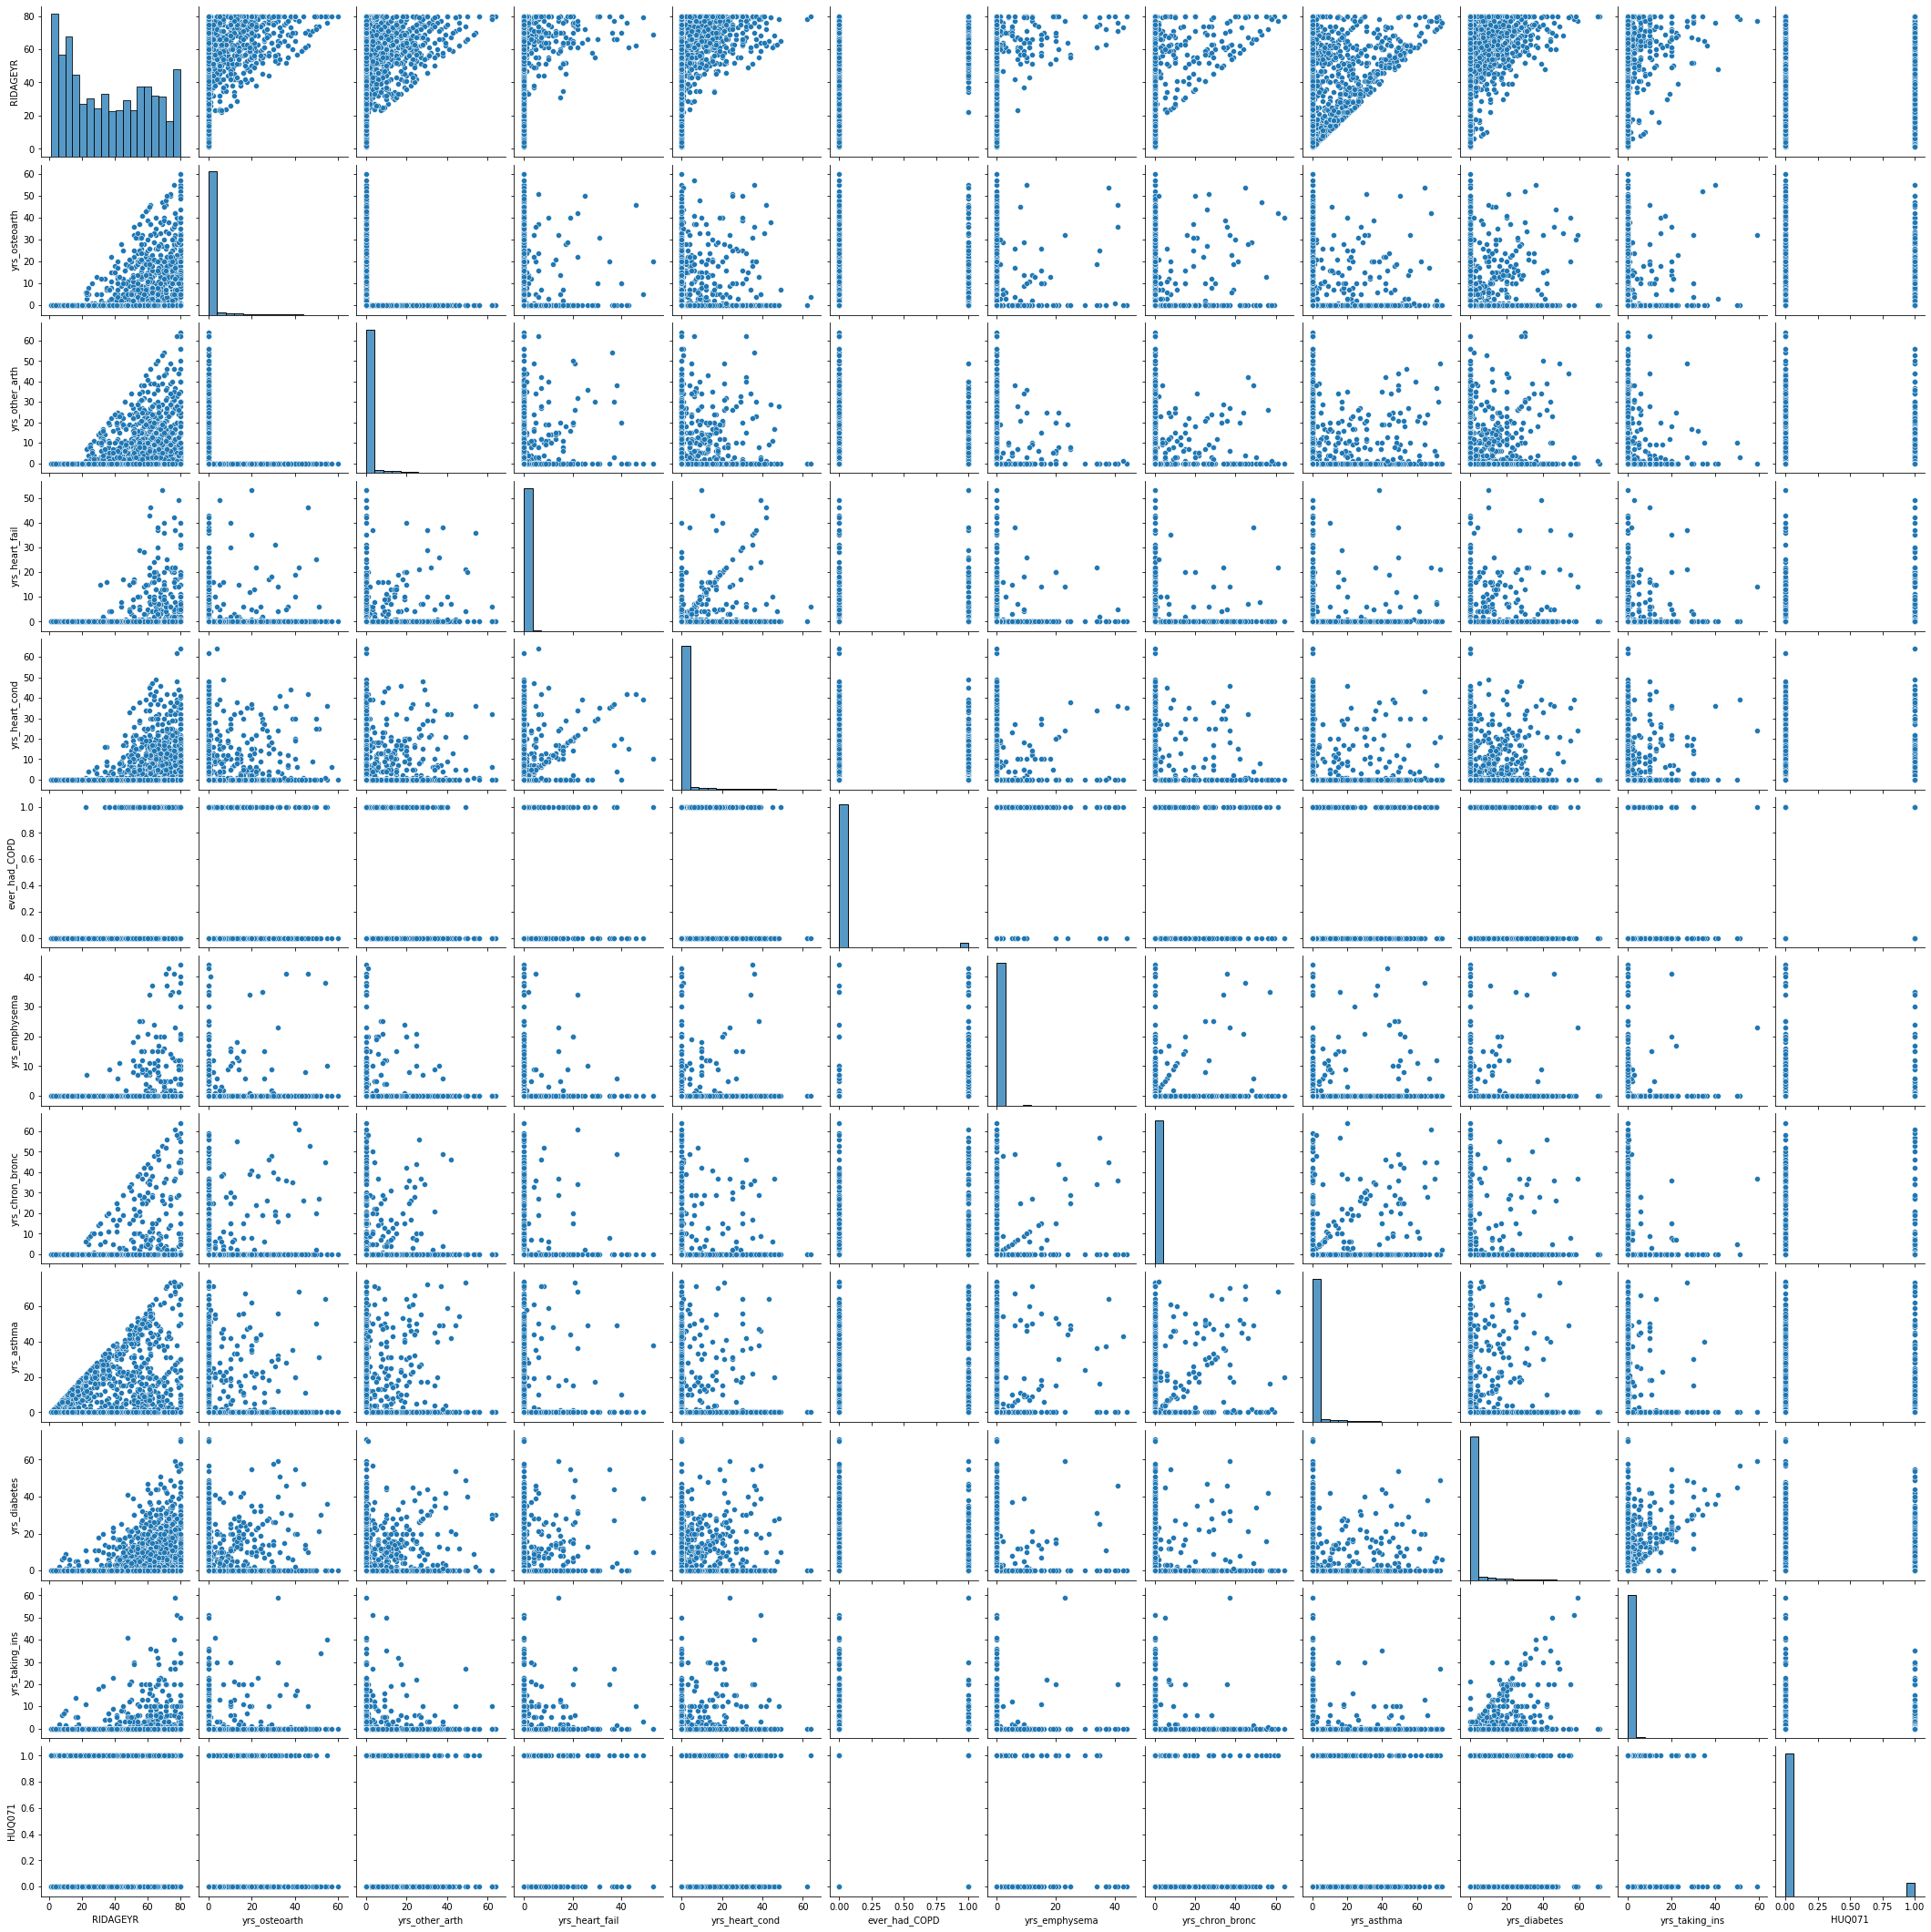

In [4]:
sns.pairplot(yrs_df_3)


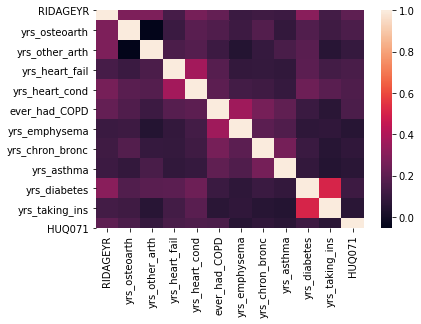

In [5]:
corr = yrs_df_3.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)

In [6]:
# define X and y

X = yrs_df_3.drop(columns = ['HUQ071'])
y = yrs_df_3['HUQ071']


In [7]:
# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)


# look at cross_validate instead of doing by hand

In [8]:
def k_fold_validator(X, y, classifier, cv=5):

    """Uses k-fold cross-validation to calculate the mean recall, precision, and f1 scores 
    for train and test sets for a model.  Also plots a confusion matrix for each test set.
    
    Parameters
    ----------
    
    X : DataFrame, Predictors
    
    y : series, Labels assigned
    
    classifier : An instance of a classifier.
    
    cv : int, How many folds to use when cross-validating.  Default = 5.
    
    Returns
    -------
    
    No objects returned.
    
    Prints mean recall, precision, and f1 scores for train and test sets.
    
    Plots a confusion matrix for each test set."""
    
    kf = KFold(n_splits=cv, random_state=727, shuffle=True)
    clf = classifier

    train_recall_scores = []
    train_precision_scores = []
    train_f1_scores = []
    test_recall_scores = []
    test_precision_scores = []
    test_f1_scores = []
    
    print('Classifier:', clf)
    print('Cross-validation folds:', cv)
    
    print('\n')
    print('Mean ROC-AUC Score:', round(cross_val_score(clf, X, y, scoring='roc_auc').mean(), 3))
    
    
    for train_index, test_index in kf.split(X):

        X_tr, X_test = X.iloc[train_index].astype(str), X.iloc[test_index].astype(str)
        y_tr, y_test = y.iloc[train_index].astype(str), y.iloc[test_index].astype(str)
        
        clf.fit(X_tr, y_tr)

        y_pred_tr = clf.predict(X_tr)
        y_pred_test = clf.predict(X_test)

        train_recall_scores.append(recall_score(y_tr, y_pred_tr, pos_label='1.0'))
        train_precision_scores.append(precision_score(y_tr, y_pred_tr, pos_label='1.0'))
        train_f1_scores.append(f1_score(y_tr, y_pred_tr, pos_label='1.0'))       
        test_recall_scores.append(recall_score(y_test, y_pred_test, pos_label='1.0'))
        test_precision_scores.append(precision_score(y_test, y_pred_test, pos_label='1.0'))
        test_f1_scores.append(f1_score(y_test, y_pred_test, pos_label='1.0'))       
        
        plot_confusion_matrix(clf, X_test, y_test)
        plt.title('Test set')
        
    print('\n')
    
    print('Train mean recall: {} +/- {}'.format(round(pd.Series(train_recall_scores).mean(), 2), 
                                               round(pd.Series(train_recall_scores).std(), 2)))
    
    print('Train mean precision: {} +/- {}'.format(round(pd.Series(train_precision_scores).mean(), 2),
                                                  round(pd.Series(train_precision_scores).std(), 2)))
    
    print('Train mean F1: {} +/- {}'.format(round(pd.Series(train_f1_scores).mean(), 2),
                                           round(pd.Series(train_f1_scores).std(), 2)))
    print('\n')
    
    print('Test mean recall: {} +/- {}'.format(round(pd.Series(test_recall_scores).mean(), 2),
                                               round(pd.Series(test_recall_scores).std(), 2)))
    
    print('Test mean precision: {} +/- {}'.format(round(pd.Series(test_precision_scores).mean(), 2),
                                                  round(pd.Series(test_precision_scores).std(), 2)))
    
    print('Test mean F1: {} +/- {}'.format(round(pd.Series(test_f1_scores).mean(), 2),
                                           round(pd.Series(test_f1_scores).std(), 2)))

In [9]:
def order_features(weights, X_train):
    
    coef_dict = {}

    for n, c in enumerate(X_train.columns):
        coef_dict[c]=round(weights[0][n],4)

    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}
    df = pd.DataFrame.from_dict(sorted_coef_dict, orient='index', columns=['weight'])
    df['abs_weight']=np.abs(df['weight'])
    weights_df = df.sort_values(by = 'abs_weight', ascending=False)
    
    return weights_df


def order_features_tree(weights, X_train):
    
    coef_dict = {}

    for n, c in enumerate(X_train.columns):
        coef_dict[c]=round(weights[n],4)

    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}
    df = pd.DataFrame.from_dict(sorted_coef_dict, orient='index', columns=['weight'])
    df['abs_weight']=np.abs(df['weight'])
    weights_df = df.sort_values(by = 'abs_weight', ascending=False)
    
    return weights_df


def k_fold_validator_2(X, y, classifier, cv=5):

    """Uses k-fold cross-validation to calculate the mean recall, precision, and f1 scores 
    for train and test sets for a model.  Also plots a confusion matrix for each test set.
    
    Parameters
    ----------
    
    X : DataFrame, Predictors
    
    y : series, Labels assigned
    
    classifier : An instance of a classifier.
    
    cv : int, How many folds to use when cross-validating.  Default = 5.
    
    Returns
    -------
    
    No objects returned.
    
    Prints mean recall, precision, and f1 scores for train and test sets.
    
    Plots a confusion matrix for each test set."""
    
    scaler = MinMaxScaler()

    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    
    kf = KFold(n_splits=cv, random_state=727, shuffle=True)
    clf = classifier

    train_recall_scores = []
    train_precision_scores = []
    train_f1_scores = []
    test_recall_scores = []
    test_precision_scores = []
    test_f1_scores = []
    
    print('Classifier:', clf)
    print('Cross-validation folds:', cv)
    
    print('\n')
    print('Mean ROC-AUC Score:', round(cross_val_score(clf, X_scaled, y, scoring='roc_auc').mean(), 3))
    
    
    for train_index, test_index in kf.split(X_scaled):

        X_tr, X_test = X_scaled.iloc[train_index].astype(str), X_scaled.iloc[test_index].astype(str)
        y_tr, y_test = y.iloc[train_index].astype(str), y.iloc[test_index].astype(str)
        
        clf.fit(X_tr, y_tr)

        y_pred_tr = clf.predict(X_tr)
        y_pred_test = clf.predict(X_test)

        train_recall_scores.append(recall_score(y_tr, y_pred_tr, pos_label='1.0'))
        train_precision_scores.append(precision_score(y_tr, y_pred_tr, pos_label='1.0'))
        train_f1_scores.append(f1_score(y_tr, y_pred_tr, pos_label='1.0'))       
        test_recall_scores.append(recall_score(y_test, y_pred_test, pos_label='1.0'))
        test_precision_scores.append(precision_score(y_test, y_pred_test, pos_label='1.0'))
        test_f1_scores.append(f1_score(y_test, y_pred_test, pos_label='1.0'))       
        
        plot_confusion_matrix(clf, X_test, y_test)
        plt.title('Test set')
        
    print('\n')
    
    print('Train mean recall: {} +/- {}'.format(round(pd.Series(train_recall_scores).mean(), 2), 
                                               round(pd.Series(train_recall_scores).std(), 2)))
    
    print('Train mean precision: {} +/- {}'.format(round(pd.Series(train_precision_scores).mean(), 2),
                                                  round(pd.Series(train_precision_scores).std(), 2)))
    
    print('Train mean F1: {} +/- {}'.format(round(pd.Series(train_f1_scores).mean(), 2),
                                           round(pd.Series(train_f1_scores).std(), 2)))
    print('\n')
    
    print('Test mean recall: {} +/- {}'.format(round(pd.Series(test_recall_scores).mean(), 2),
                                               round(pd.Series(test_recall_scores).std(), 2)))
    
    print('Test mean precision: {} +/- {}'.format(round(pd.Series(test_precision_scores).mean(), 2),
                                                  round(pd.Series(test_precision_scores).std(), 2)))
    
    print('Test mean F1: {} +/- {}'.format(round(pd.Series(test_f1_scores).mean(), 2),
                                           round(pd.Series(test_f1_scores).std(), 2)))
    print('\n')
    
    if type(clf) == DecisionTreeClassifier:
        features = order_features_tree(clf.feature_importances_, X_scaled)
    elif type(clf) == KNeighborsClassifier:
        pass
    else:
        features = order_features(clf.coef_, X_scaled)
    
    if type(clf) != KNeighborsClassifier:
        print('Feature weights:', '\n', features, '\n')
        print('Confusion matrices for each fold test set:', '\n')
    

Classifier: LogisticRegression(max_iter=10000)
Cross-validation folds: 5


Mean ROC-AUC Score: 0.724


Train mean recall: 0.03 +/- 0.0
Train mean precision: 0.57 +/- 0.01
Train mean F1: 0.06 +/- 0.01


Test mean recall: 0.03 +/- 0.01
Test mean precision: 0.53 +/- 0.14
Test mean F1: 0.05 +/- 0.01


Feature weights: 
                   weight  abs_weight
RIDAGEYR         1.68120     1.68120
yrs_heart_fail   1.56930     1.56930
yrs_osteoarth    1.47640     1.47640
yrs_heart_cond   1.11100     1.11100
yrs_diabetes     0.72510     0.72510
ever_had_COPD    0.70780     0.70780
yrs_other_arth   0.59290     0.59290
yrs_asthma       0.48970     0.48970
yrs_emphysema   -0.23790     0.23790
yrs_chron_bronc -0.18990     0.18990
yrs_taking_ins  -0.10070     0.10070 

Confusion matrices for each fold test set: 



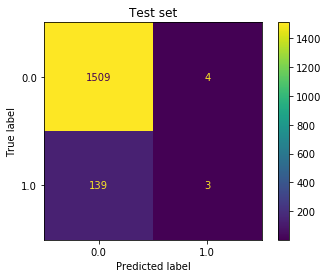

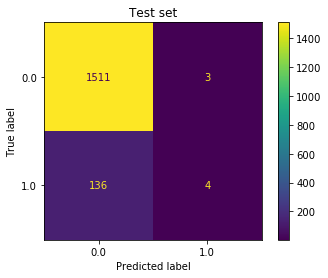

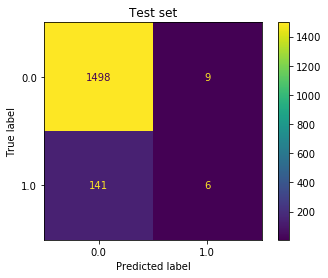

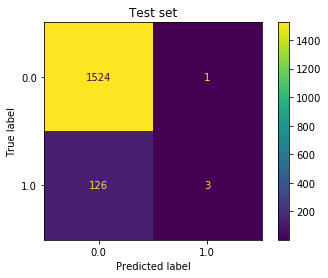

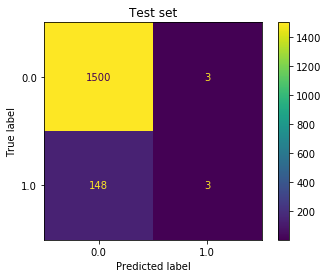

In [10]:
k_fold_validator_2(X=X_training, y=y_training, classifier=LogisticRegression(max_iter=10000), cv=5)


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.553


Train mean recall: 0.3 +/- 0.01
Train mean precision: 0.28 +/- 0.01
Train mean F1: 0.29 +/- 0.01


Test mean recall: 0.3 +/- 0.02
Test mean precision: 0.28 +/- 0.04
Test mean F1: 0.29 +/- 0.03


Feature weights: 
                  weight  abs_weight
yrs_emphysema   5.38650     5.38650
yrs_heart_fail  5.16960     5.16960
yrs_taking_ins  4.89930     4.89930
yrs_chron_bronc 4.71160     4.71160
yrs_heart_cond  3.92950     3.92950
yrs_osteoarth   3.57390     3.57390
yrs_diabetes    3.52370     3.52370
yrs_other_arth  3.46180     3.46180
yrs_asthma      3.27440     3.27440
ever_had_COPD   3.05650     3.05650
RIDAGEYR        0.24870     0.24870 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


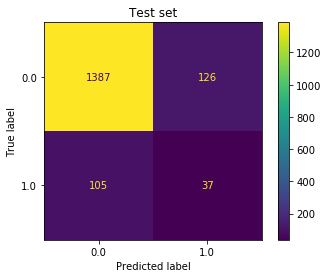

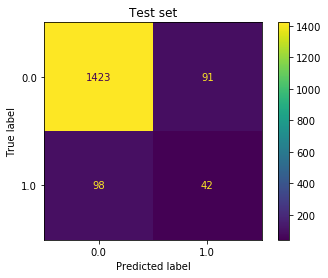

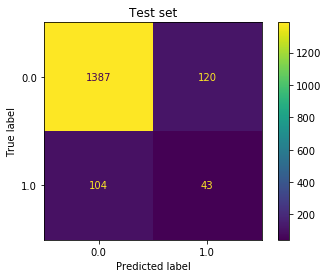

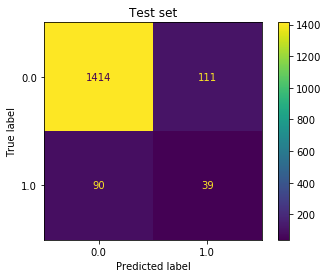

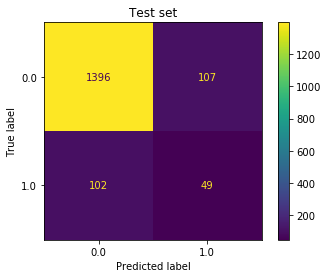

In [11]:
# try a complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

Classifier: DecisionTreeClassifier(max_depth=6, min_samples_split=15)
Cross-validation folds: 5


Mean ROC-AUC Score: 0.707


Train mean recall: 0.12 +/- 0.02
Train mean precision: 0.8 +/- 0.04
Train mean F1: 0.21 +/- 0.02


Test mean recall: 0.04 +/- 0.02
Test mean precision: 0.28 +/- 0.06
Test mean F1: 0.07 +/- 0.02


Feature weights: 
                  weight  abs_weight
yrs_heart_cond  0.33130     0.33130
RIDAGEYR        0.20630     0.20630
yrs_heart_fail  0.14560     0.14560
yrs_osteoarth   0.10470     0.10470
yrs_diabetes    0.04800     0.04800
yrs_emphysema   0.03960     0.03960
yrs_other_arth  0.03660     0.03660
yrs_taking_ins  0.03510     0.03510
ever_had_COPD   0.03480     0.03480
yrs_asthma      0.00920     0.00920
yrs_chron_bronc 0.00900     0.00900 

Confusion matrices for each fold test set: 



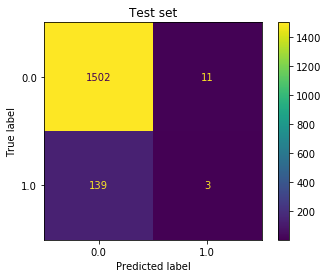

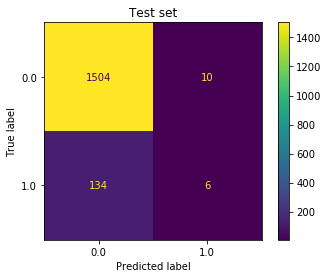

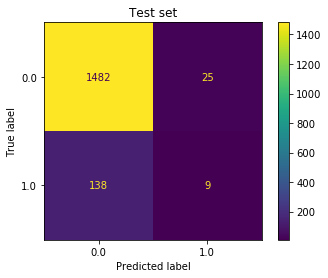

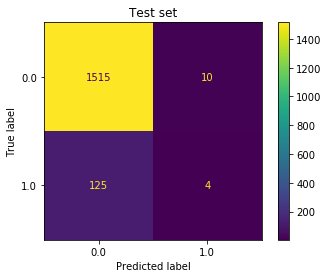

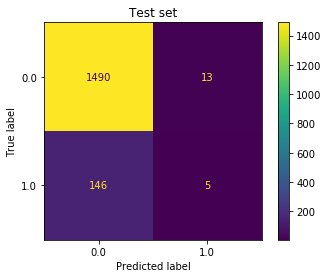

In [12]:
# try a decision tree

tree = DecisionTreeClassifier(max_depth=6, min_samples_split=15)

k_fold_validator_2(X_training, y_training, tree)

In [13]:
# other features to try:
# cancer
# lang spoken at home
# depression
# alcohol-related disorders
# childbirth - exclude 70 ppl who had babies in the past 12 months? RHQ197 - How many months ago have baby?
# sickle cell
# language

# other things to try:
# svm
# neural net

In [14]:
binary_df = pd.read_csv('data/binary_df').set_index('SEQN')

In [15]:
# minority class is just 8.5 %

binary_df['HUQ071'].value_counts(normalize=True)

0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

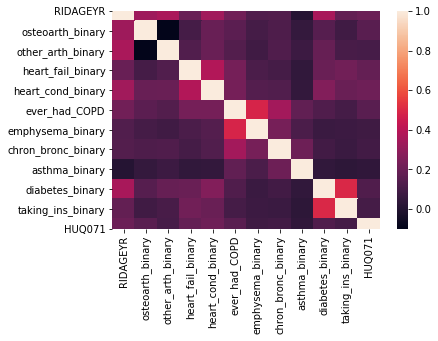

In [18]:
corr = binary_df.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)

In [19]:
# define X and y

X = binary_df.drop(columns = 'HUQ071')
y = binary_df['HUQ071']

In [20]:
# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.605


Train mean recall: 0.42 +/- 0.01
Train mean precision: 0.26 +/- 0.02
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.41 +/- 0.06
Test mean precision: 0.26 +/- 0.04
Test mean F1: 0.32 +/- 0.05


Feature weights: 
                     weight  abs_weight
emphysema_binary   4.63770     4.63770
heart_fail_binary  4.10030     4.10030
chron_bronc_binary 4.07800     4.07800
taking_ins_binary  3.61910     3.61910
ever_had_COPD      3.55850     3.55850
heart_cond_binary  2.80510     2.80510
osteoarth_binary   2.60250     2.60250
diabetes_binary    2.35450     2.35450
asthma_binary      2.33700     2.33700
other_arth_binary  2.26990     2.26990
RIDAGEYR           0.75070     0.75070 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


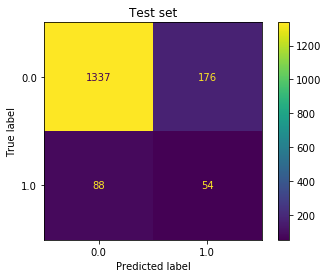

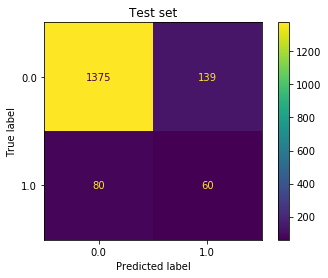

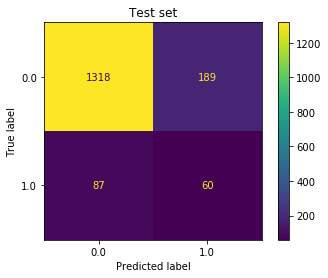

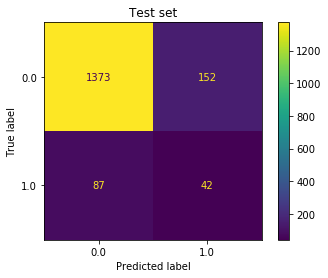

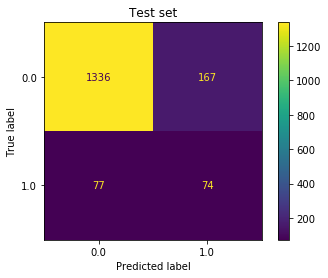

In [21]:
# try a complement naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

Classifier: LogisticRegression()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.734


Train mean recall: 0.05 +/- 0.01
Train mean precision: 0.51 +/- 0.04
Train mean F1: 0.09 +/- 0.02


Test mean recall: 0.05 +/- 0.01
Test mean precision: 0.52 +/- 0.2
Test mean F1: 0.09 +/- 0.02


Feature weights: 
                      weight  abs_weight
RIDAGEYR            1.35610     1.35610
heart_fail_binary   0.82520     0.82520
osteoarth_binary    0.67730     0.67730
heart_cond_binary   0.60410     0.60410
ever_had_COPD       0.49770     0.49770
other_arth_binary   0.28310     0.28310
asthma_binary       0.27450     0.27450
diabetes_binary     0.15790     0.15790
chron_bronc_binary  0.09920     0.09920
taking_ins_binary   0.04660     0.04660
emphysema_binary   -0.03290     0.03290 

Confusion matrices for each fold test set: 



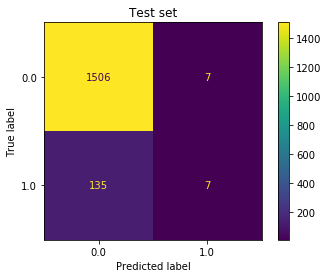

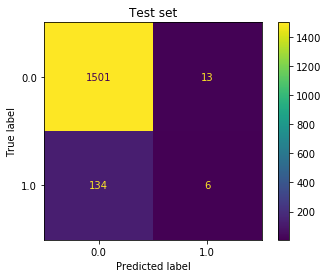

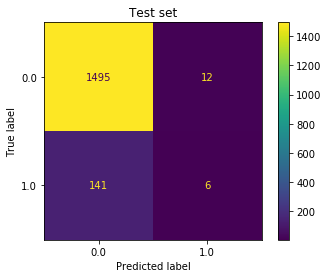

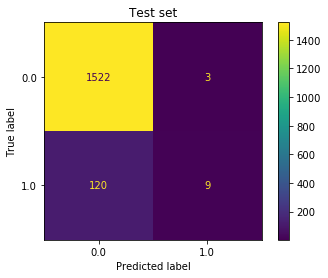

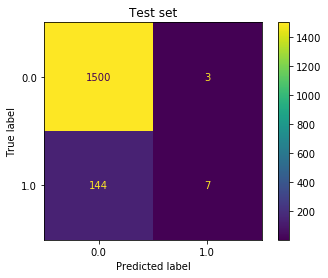

In [22]:
# try a Logistic Regression

logreg = LogisticRegression()

k_fold_validator_2(X_training, y_training, logreg)

Classifier: DecisionTreeClassifier(max_depth=6, min_samples_split=15)
Cross-validation folds: 5


Mean ROC-AUC Score: 0.7


Train mean recall: 0.08 +/- 0.02
Train mean precision: 0.73 +/- 0.02
Train mean F1: 0.15 +/- 0.03


Test mean recall: 0.03 +/- 0.01
Test mean precision: 0.31 +/- 0.1
Test mean F1: 0.06 +/- 0.02


Feature weights: 
                     weight  abs_weight
RIDAGEYR           0.36890     0.36890
heart_cond_binary  0.30670     0.30670
heart_fail_binary  0.08000     0.08000
ever_had_COPD      0.06130     0.06130
osteoarth_binary   0.04890     0.04890
diabetes_binary    0.04740     0.04740
other_arth_binary  0.02740     0.02740
chron_bronc_binary 0.02570     0.02570
taking_ins_binary  0.02170     0.02170
asthma_binary      0.00750     0.00750
emphysema_binary   0.00450     0.00450 

Confusion matrices for each fold test set: 



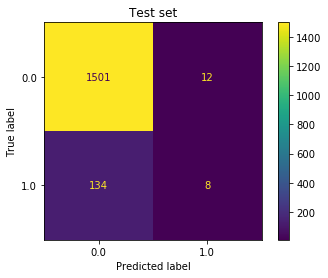

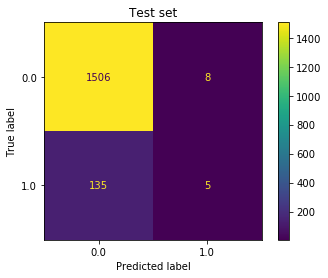

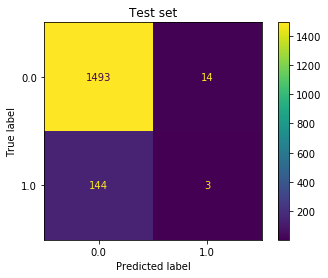

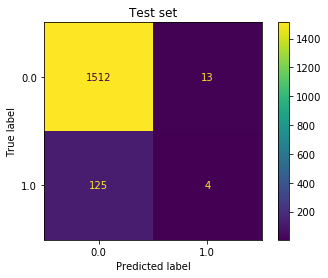

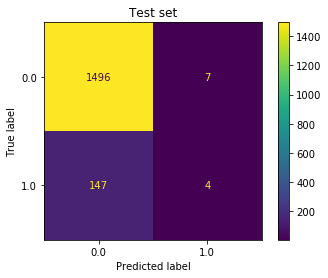

In [23]:
# try a decision tree

tree = DecisionTreeClassifier(max_depth=6, min_samples_split=15)

k_fold_validator_2(X_training, y_training, tree)

In [24]:
# try with updated non-birth hospitalizations

binary_df_2 = pd.read_csv('data/binary_df_2').set_index('SEQN')
binary_df_2

RIDAGEYR  osteoarth_binary  other_arth_binary  \
SEQN                                                          
93703.00000    2.00000           0.00000            0.00000   
93704.00000    2.00000           0.00000            0.00000   
93705.00000   66.00000           0.00000            1.00000   
93706.00000   18.00000           0.00000            0.00000   
93707.00000   13.00000           0.00000            0.00000   
...                ...               ...                ...   
102952.00000  70.00000           0.00000            0.00000   
102953.00000  42.00000           0.00000            0.00000   
102954.00000  41.00000           0.00000            0.00000   
102955.00000  14.00000           0.00000            0.00000   
102956.00000  38.00000           1.00000            0.00000   

              heart_fail_binary  heart_cond_binary  ever_had_COPD  \
SEQN                                                                
93703.00000             0.00000            0.00000        0.00000   
93704.00000             0.00000            0.00000        0.00000   
93705.00000             0.00000            0.00000        0.00000   
93706.00000             0.00000            0.00000        0.00000   
93707.00000             0.00000            0.00000        0.00000   
...                         ...                ...            ...   
102952.00000            0.00000            0.00000        0.00000   
102953.00000            0.00000            0.00000        0.00000   
102954.00000            0.00000            0.00000        0.00000   
102955.00000            0.00000            0.00000        0.00000   
102956.00000            0.00000            0.00000        0.00000   

              emphysema_binary  chron_bronc_binary  asthma_binary  \
SEQN                                                                
93703.00000            0.00000             0.00000        0.00000   
93704.00000            0.00000             0.00000        0.00000   
93705.00000            0.00000             0.00000        0.00000   
93706.00000            0.00000             0.00000        0.00000   
93707.00000            0.00000             0.00000        0.00000   
...                        ...                 ...            ...   
102952.00000           0.00000             0.00000        0.00000   
102953.00000           0.00000             0.00000        0.00000   
102954.00000           0.00000             0.00000        0.00000   
102955.00000           0.00000             0.00000        0.00000   
102956.00000           0.00000             0.00000        0.00000   

              diabetes_binary  taking_ins_binary  updated_hosp  
SEQN                                                            
93703.00000           0.00000            0.00000       0.00000  
93704.00000           0.00000            0.00000       0.00000  
93705.00000           0.00000            0.00000       0.00000  
93706.00000           0.00000            0.00000       0.00000  
93707.00000           0.00000            0.00000       0.00000  
...                       ...                ...           ...  
102952.00000          0.00000            0.00000       0.00000  
102953.00000          0.00000            0.00000       0.00000  
102954.00000          0.00000            0.00000       0.00000  
102955.00000          0.00000            0.00000       0.00000  
102956.00000          0.00000            0.00000       0.00000  

[8894 rows x 12 columns]

In [25]:
# define X and y

X = binary_df_2.drop(columns = 'updated_hosp')
y = binary_df_2['updated_hosp']

In [26]:
# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.617


Train mean recall: 0.44 +/- 0.02
Train mean precision: 0.26 +/- 0.01
Train mean F1: 0.33 +/- 0.01


Test mean recall: 0.43 +/- 0.06
Test mean precision: 0.26 +/- 0.04
Test mean F1: 0.32 +/- 0.05


Feature weights: 
                     weight  abs_weight
emphysema_binary   4.64100     4.64100
heart_fail_binary  4.10360     4.10360
chron_bronc_binary 4.08140     4.08140
taking_ins_binary  3.62250     3.62250
ever_had_COPD      3.56180     3.56180
heart_cond_binary  2.80850     2.80850
osteoarth_binary   2.60580     2.60580
diabetes_binary    2.35790     2.35790
asthma_binary      2.32890     2.32890
other_arth_binary  2.27330     2.27330
RIDAGEYR           0.74930     0.74930 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


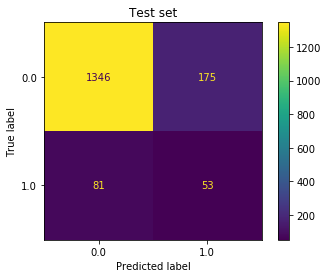

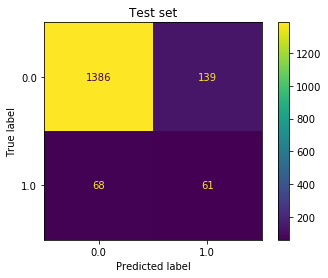

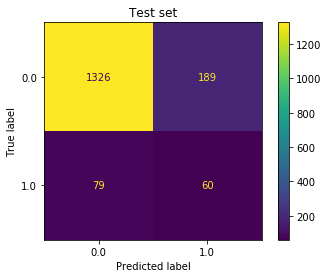

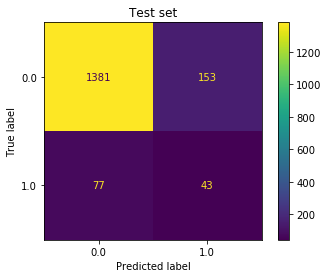

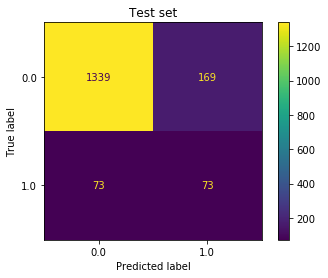

In [27]:
# try a complement naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

Classifier: LogisticRegression()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.75


Train mean recall: 0.06 +/- 0.01
Train mean precision: 0.52 +/- 0.04
Train mean F1: 0.1 +/- 0.02


Test mean recall: 0.05 +/- 0.01
Test mean precision: 0.51 +/- 0.22
Test mean F1: 0.09 +/- 0.03


Feature weights: 
                      weight  abs_weight
RIDAGEYR            1.50900     1.50900
heart_fail_binary   0.82030     0.82030
osteoarth_binary    0.74070     0.74070
heart_cond_binary   0.62300     0.62300
ever_had_COPD       0.52440     0.52440
other_arth_binary   0.34930     0.34930
asthma_binary       0.21720     0.21720
diabetes_binary     0.19330     0.19330
chron_bronc_binary  0.12190     0.12190
taking_ins_binary   0.04360     0.04360
emphysema_binary   -0.03100     0.03100 

Confusion matrices for each fold test set: 



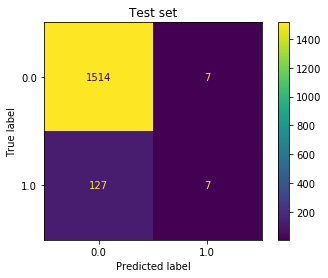

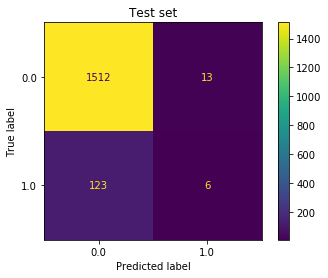

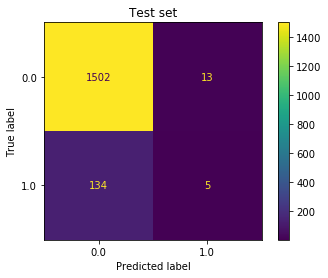

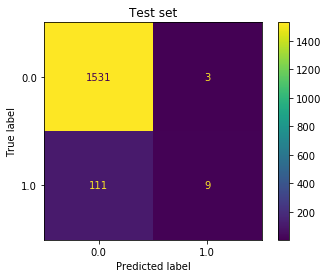

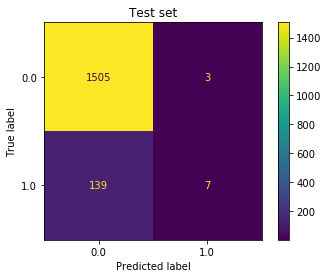

In [28]:
# try a Logistic Regression

logreg = LogisticRegression()

k_fold_validator_2(X_training, y_training, logreg)

Classifier: DecisionTreeClassifier(max_depth=6, min_samples_split=15)
Cross-validation folds: 5


Mean ROC-AUC Score: 0.691


Train mean recall: 0.09 +/- 0.02
Train mean precision: 0.73 +/- 0.03
Train mean F1: 0.16 +/- 0.03


Test mean recall: 0.04 +/- 0.01
Test mean precision: 0.26 +/- 0.09
Test mean F1: 0.06 +/- 0.02


Feature weights: 
                     weight  abs_weight
RIDAGEYR           0.31600     0.31600
heart_cond_binary  0.30350     0.30350
heart_fail_binary  0.07500     0.07500
ever_had_COPD      0.07140     0.07140
osteoarth_binary   0.06860     0.06860
diabetes_binary    0.04020     0.04020
other_arth_binary  0.03660     0.03660
chron_bronc_binary 0.02820     0.02820
asthma_binary      0.02290     0.02290
taking_ins_binary  0.02030     0.02030
emphysema_binary   0.01720     0.01720 

Confusion matrices for each fold test set: 



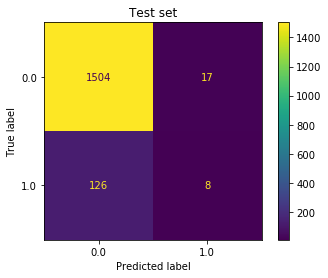

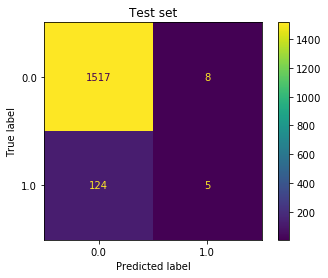

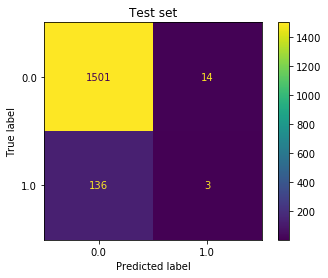

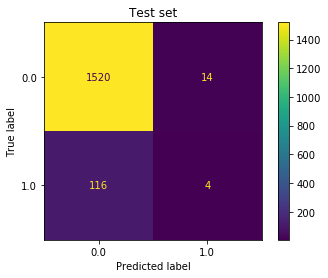

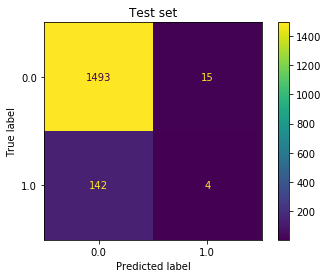

In [29]:
# try a decision tree

tree = DecisionTreeClassifier(max_depth=6, min_samples_split=15)

k_fold_validator_2(X_training, y_training, tree)

In [30]:
# add race

binary_df_3 = pd.read_csv('data/binary_df_3').set_index('SEQN')
binary_df_3.head(200)

RIDAGEYR  osteoarth_binary  other_arth_binary  heart_fail_binary  \
SEQN                                                                            
93703.00000   2.00000           0.00000            0.00000            0.00000   
93704.00000   2.00000           0.00000            0.00000            0.00000   
93705.00000  66.00000           0.00000            1.00000            0.00000   
93706.00000  18.00000           0.00000            0.00000            0.00000   
93707.00000  13.00000           0.00000            0.00000            0.00000   
93708.00000  66.00000           0.00000            0.00000            0.00000   
93709.00000  75.00000           0.00000            1.00000            0.00000   
93711.00000  56.00000           0.00000            0.00000            0.00000   
93712.00000  18.00000           0.00000            0.00000            0.00000   
93713.00000  67.00000           0.00000            1.00000            0.00000   
93714.00000  54.00000           0.00000            0.00000            0.00000   
93715.00000  71.00000           1.00000            0.00000            0.00000   
93716.00000  61.00000           0.00000            1.00000            0.00000   
93717.00000  22.00000           0.00000            0.00000            0.00000   
93718.00000  45.00000           0.00000            0.00000            0.00000   
93719.00000  13.00000           0.00000            0.00000            0.00000   
93720.00000   1.00000           0.00000            0.00000            0.00000   
93721.00000  60.00000           0.00000            0.00000            0.00000   
93722.00000  60.00000           0.00000            0.00000            0.00000   
93723.00000  64.00000           1.00000            0.00000            0.00000   
93724.00000   5.00000           0.00000            0.00000            0.00000   
93725.00000   9.00000           0.00000            0.00000            0.00000   
93726.00000  67.00000           0.00000            0.00000            0.00000   
93727.00000  70.00000           0.00000            0.00000            0.00000   
93728.00000  53.00000           0.00000            0.00000            0.00000   
93729.00000  42.00000           0.00000            0.00000            0.00000   
93730.00000  57.00000           0.00000            0.00000            0.00000   
93731.00000  20.00000           0.00000            0.00000            0.00000   
93732.00000  72.00000           0.00000            0.00000            0.00000   
93733.00000  11.00000           0.00000            0.00000            0.00000   
93734.00000  13.00000           0.00000            0.00000            0.00000   
93735.00000  52.00000           0.00000            0.00000            0.00000   
93736.00000  11.00000           0.00000            0.00000            0.00000   
93737.00000   8.00000           0.00000            0.00000            0.00000   
93738.00000  26.00000           0.00000            0.00000            0.00000   
93739.00000   5.00000           0.00000            0.00000            0.00000   
93740.00000  72.00000           0.00000            1.00000            1.00000   
93741.00000   9.00000           0.00000            0.00000            0.00000   
93742.00000  72.00000           1.00000            0.00000            0.00000   
93743.00000  61.00000           0.00000            1.00000            0.00000   
93744.00000  10.00000           0.00000            0.00000            0.00000   
93745.00000   5.00000           0.00000            0.00000            0.00000   
93746.00000  25.00000           0.00000            0.00000            0.00000   
93747.00000  13.00000           0.00000            0.00000            0.00000   
93749.00000   1.00000           0.00000            0.00000            0.00000   
93750.00000  52.00000           0.00000            0.00000            0.00000   
93751.00000   7.00000           0.00000            0.00000            0.00000   
93752.00000  73.00000           0.00000     

In [31]:
# define X and y

X = binary_df_3.drop(columns = 'updated_hosp')
y = binary_df_3['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.714


Train mean recall: 0.53 +/- 0.02
Train mean precision: 0.24 +/- 0.01
Train mean F1: 0.33 +/- 0.01


Test mean recall: 0.53 +/- 0.04
Test mean precision: 0.23 +/- 0.03
Test mean F1: 0.32 +/- 0.04


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.36070     5.36070
heart_fail_binary  4.82330     4.82330
chron_bronc_binary 4.80110     4.80110
taking_ins_binary  4.34220     4.34220
ever_had_COPD      4.28150     4.28150
heart_cond_binary  3.52820     3.52820
osteoarth_binary   3.32550     3.32550
diabetes_binary    3.07760     3.07760
asthma_binary      3.04860     3.04860
RIDRETH3_2.0       3.03160     3.03160
other_arth_binary  2.99300     2.99300
RIDRETH3_6.0       2.61130     2.61130
RIDRETH3_1.0       2.47460     2.47460
RIDRETH3_4.0       2.05920     2.05920
RIDRETH3_3.0       1.71660     1.71660
RIDAGEYR           1.46900     1.46900 

Confusion matrices for each fold tes

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


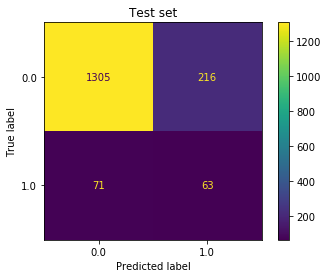

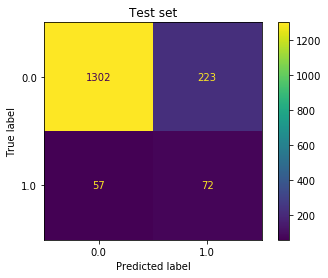

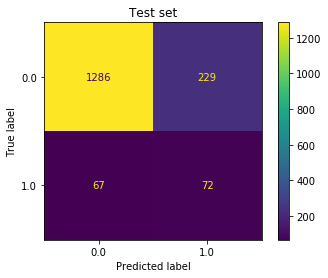

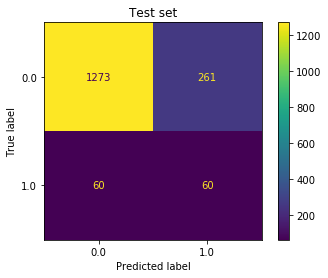

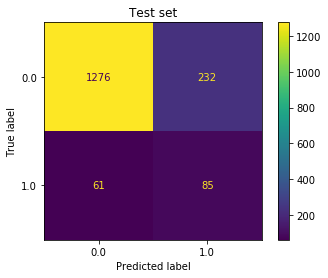

In [32]:
CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

In [33]:
# add number of prescriptions per patient

binary_df_4 = pd.read_csv('data/binary_df_4').set_index('SEQN')
binary_df_4.head(200)

RIDAGEYR  osteoarth_binary  other_arth_binary  heart_fail_binary  \
SEQN                                                                            
93703.00000   2.00000           0.00000            0.00000            0.00000   
93704.00000   2.00000           0.00000            0.00000            0.00000   
93705.00000  66.00000           0.00000            1.00000            0.00000   
93706.00000  18.00000           0.00000            0.00000            0.00000   
93707.00000  13.00000           0.00000            0.00000            0.00000   
93708.00000  66.00000           0.00000            0.00000            0.00000   
93709.00000  75.00000           0.00000            1.00000            0.00000   
93711.00000  56.00000           0.00000            0.00000            0.00000   
93712.00000  18.00000           0.00000            0.00000            0.00000   
93713.00000  67.00000           0.00000            1.00000            0.00000   
93714.00000  54.00000           0.00000            0.00000            0.00000   
93715.00000  71.00000           1.00000            0.00000            0.00000   
93716.00000  61.00000           0.00000            1.00000            0.00000   
93717.00000  22.00000           0.00000            0.00000            0.00000   
93718.00000  45.00000           0.00000            0.00000            0.00000   
93719.00000  13.00000           0.00000            0.00000            0.00000   
93720.00000   1.00000           0.00000            0.00000            0.00000   
93721.00000  60.00000           0.00000            0.00000            0.00000   
93722.00000  60.00000           0.00000            0.00000            0.00000   
93723.00000  64.00000           1.00000            0.00000            0.00000   
93724.00000   5.00000           0.00000            0.00000            0.00000   
93725.00000   9.00000           0.00000            0.00000            0.00000   
93726.00000  67.00000           0.00000            0.00000            0.00000   
93727.00000  70.00000           0.00000            0.00000            0.00000   
93728.00000  53.00000           0.00000            0.00000            0.00000   
93729.00000  42.00000           0.00000            0.00000            0.00000   
93730.00000  57.00000           0.00000            0.00000            0.00000   
93731.00000  20.00000           0.00000            0.00000            0.00000   
93732.00000  72.00000           0.00000            0.00000            0.00000   
93733.00000  11.00000           0.00000            0.00000            0.00000   
93734.00000  13.00000           0.00000            0.00000            0.00000   
93735.00000  52.00000           0.00000            0.00000            0.00000   
93736.00000  11.00000           0.00000            0.00000            0.00000   
93737.00000   8.00000           0.00000            0.00000            0.00000   
93738.00000  26.00000           0.00000            0.00000            0.00000   
93739.00000   5.00000           0.00000            0.00000            0.00000   
93740.00000  72.00000           0.00000            1.00000            1.00000   
93741.00000   9.00000           0.00000            0.00000            0.00000   
93742.00000  72.00000           1.00000            0.00000            0.00000   
93743.00000  61.00000           0.00000            1.00000            0.00000   
93744.00000  10.00000           0.00000            0.00000            0.00000   
93745.00000   5.00000           0.00000            0.00000            0.00000   
93746.00000  25.00000           0.00000            0.00000            0.00000   
93747.00000  13.00000           0.00000            0.00000            0.00000   
93749.00000   1.00000           0.00000            0.00000            0.00000   
93750.00000  52.00000           0.00000            0.00000            0.00000   
93751.00000   7.00000           0.00000            0.00000            0.00000   
93752.00000  73.00000           0.00000     

In [34]:
# define X and y

X = binary_df_4.drop(columns = ['updated_hosp'])
y = binary_df_4['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)



Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.726


Train mean recall: 0.54 +/- 0.01
Train mean precision: 0.23 +/- 0.01
Train mean F1: 0.33 +/- 0.01


Test mean recall: 0.54 +/- 0.05
Test mean precision: 0.23 +/- 0.03
Test mean F1: 0.32 +/- 0.04


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.39110     5.39110
heart_fail_binary  4.85370     4.85370
chron_bronc_binary 4.83150     4.83150
taking_ins_binary  4.37250     4.37250
ever_had_COPD      4.31190     4.31190
heart_cond_binary  3.55850     3.55850
num_rx             3.51000     3.51000
osteoarth_binary   3.35590     3.35590
diabetes_binary    3.10790     3.10790
asthma_binary      3.07890     3.07890
RIDRETH3_2.0       3.06190     3.06190
other_arth_binary  3.02340     3.02340
RIDRETH3_6.0       2.64160     2.64160
RIDRETH3_1.0       2.50500     2.50500
RIDRETH3_4.0       2.08960     2.08960
RIDRETH3_3.0       1.74690     1.74690
RIDAGEYR           1.49930     1.49930

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


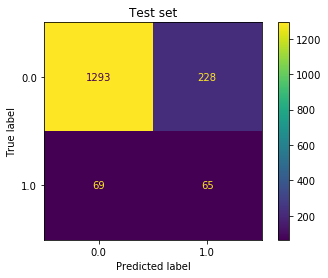

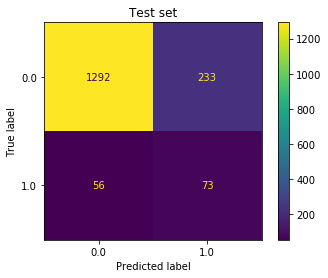

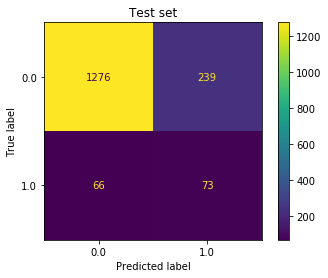

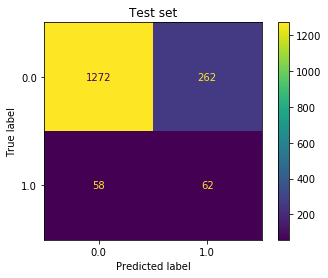

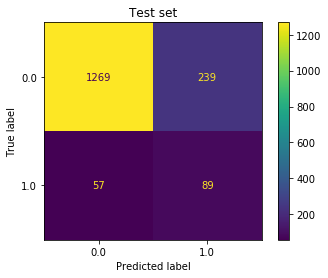

In [35]:
# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.72


Train mean recall: 0.58 +/- 0.01
Train mean precision: 0.2 +/- 0.01
Train mean F1: 0.3 +/- 0.01


Test mean recall: 0.58 +/- 0.05
Test mean precision: 0.2 +/- 0.02
Test mean F1: 0.3 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   4.88430     4.88430
heart_fail_binary  4.34690     4.34690
chron_bronc_binary 4.32470     4.32470
taking_ins_binary  3.86570     3.86570
ever_had_COPD      3.80510     3.80510
heart_cond_binary  3.05170     3.05170
num_rx             3.00320     3.00320
osteoarth_binary   2.84910     2.84910
diabetes_binary    2.60110     2.60110
asthma_binary      2.57210     2.57210
RIDRETH3_2.0       2.55510     2.55510
other_arth_binary  2.51660     2.51660
RIDRETH3_6.0       2.13480     2.13480
RIDRETH3_1.0       1.99820     1.99820
RIDRETH3_4.0       1.58280     1.58280 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


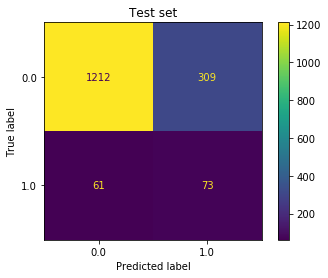

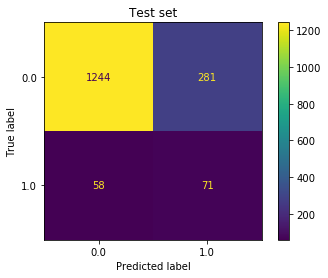

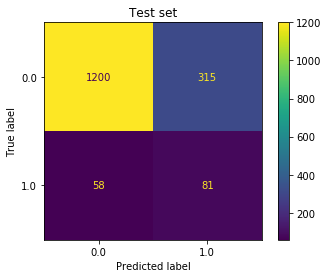

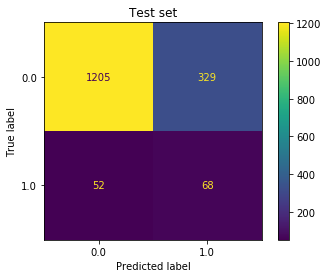

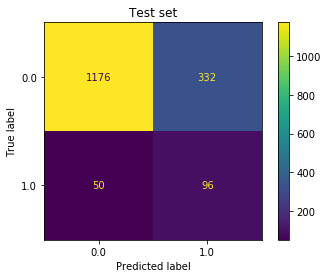

In [36]:
# drop features with lowest weights

# define X and y

X = binary_df_4.drop(columns = ['updated_hosp','RIDRETH3_3.0','RIDAGEYR'])
y = binary_df_4['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

k_fold_validator_2(X_training, y_training, CompNB)

In [37]:
binary_df_5 = pd.read_csv('data/binary_df_5').set_index('SEQN')
binary_df_5

RIDAGEYR  osteoarth_binary  other_arth_binary  \
SEQN                                                          
93703.00000    2.00000           0.00000            0.00000   
93704.00000    2.00000           0.00000            0.00000   
93705.00000   66.00000           0.00000            1.00000   
93706.00000   18.00000           0.00000            0.00000   
93707.00000   13.00000           0.00000            0.00000   
...                ...               ...                ...   
102952.00000  70.00000           0.00000            0.00000   
102953.00000  42.00000           0.00000            0.00000   
102954.00000  41.00000           0.00000            0.00000   
102955.00000  14.00000           0.00000            0.00000   
102956.00000  38.00000           1.00000            0.00000   

              heart_fail_binary  heart_cond_binary  ever_had_COPD  \
SEQN                                                                
93703.00000             0.00000            0.00000        0.00000   
93704.00000             0.00000            0.00000        0.00000   
93705.00000             0.00000            0.00000        0.00000   
93706.00000             0.00000            0.00000        0.00000   
93707.00000             0.00000            0.00000        0.00000   
...                         ...                ...            ...   
102952.00000            0.00000            0.00000        0.00000   
102953.00000            0.00000            0.00000        0.00000   
102954.00000            0.00000            0.00000        0.00000   
102955.00000            0.00000            0.00000        0.00000   
102956.00000            0.00000            0.00000        0.00000   

              emphysema_binary  chron_bronc_binary  asthma_binary  \
SEQN                                                                
93703.00000            0.00000             0.00000        0.00000   
93704.00000            0.00000             0.00000        0.00000   
93705.00000            0.00000             0.00000        0.00000   
93706.00000            0.00000             0.00000        0.00000   
93707.00000            0.00000             0.00000        0.00000   
...                        ...                 ...            ...   
102952.00000           0.00000             0.00000        0.00000   
102953.00000           0.00000             0.00000        0.00000   
102954.00000           0.00000             0.00000        0.00000   
102955.00000           0.00000             0.00000        0.00000   
102956.00000           0.00000             0.00000        0.00000   

              diabetes_binary  taking_ins_binary  updated_hosp  RIDRETH3_1.0  \
SEQN                                                                           
93703.00000           0.00000            0.00000       0.00000             0   
93704.00000           0.00000            0.00000       0.00000             0   
93705.00000           0.00000            0.00000       0.00000             0   
93706.00000           0.00000            0.00000       0.00000             0   
93707.00000           0.00000            0.00000       0.00000             0   
...                       ...                ...           ...           ...   
102952.00000          0.00000            0.00000       0.00000             0   
102953.00000          0.00000            0.00000       0.00000             1   
102954.00000          0.00000            0.00000       0.00000             0   
102955.00000          0.00000            0.00000       0.00000             0   
102956.00000          0.00000            0.00000       0.00000             0   

              RIDRETH3_2.0  RIDRETH3_3.0  RIDRETH3_4.0  RIDRETH3_6.0  num_rx  \
SEQN                                                                           
93703.00000              0             0             0             1 0.00000   
93704.00000              0             1             0             0 0.00000   
93705.00000              0           

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.73


Train mean recall: 0.56 +/- 0.01
Train mean precision: 0.24 +/- 0.01
Train mean F1: 0.33 +/- 0.01


Test mean recall: 0.55 +/- 0.05
Test mean precision: 0.24 +/- 0.03
Test mean F1: 0.33 +/- 0.04


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.40340     5.40340
heart_fail_binary  4.86600     4.86600
chron_bronc_binary 4.84380     4.84380
unknown_dx         4.40590     4.40590
taking_ins_binary  4.38480     4.38480
ever_had_COPD      4.32420     4.32420
heart_cond_binary  3.57080     3.57080
num_rx             3.52230     3.52230
osteoarth_binary   3.36820     3.36820
diabetes_binary    3.12020     3.12020
asthma_binary      3.09120     3.09120
RIDRETH3_2.0       3.07420     3.07420
other_arth_binary  3.03560     3.03560
RIDRETH3_6.0       2.65390     2.65390
RIDRETH3_1.0       2.51730     2.51730
RIDRETH3_4.0       2.10190     2.10190
RIDRETH3_3.0       1.75920     1.75920


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


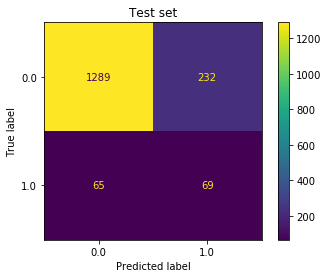

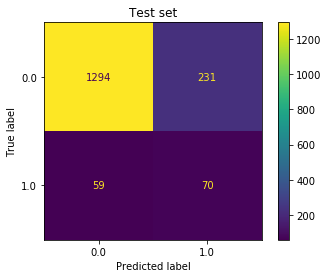

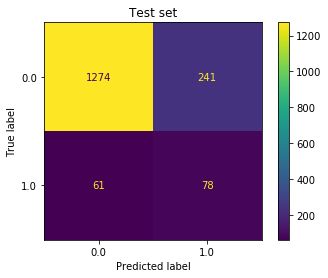

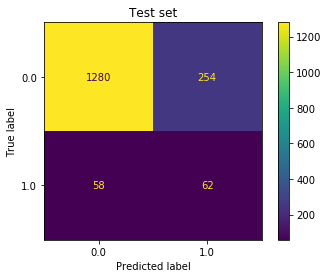

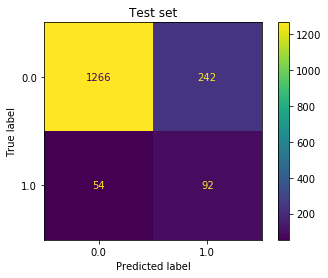

In [40]:
# define X and y

X = binary_df_5.drop(columns = ['updated_hosp'])
y = binary_df_5['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)



Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.725


Train mean recall: 0.59 +/- 0.01
Train mean precision: 0.2 +/- 0.01
Train mean F1: 0.3 +/- 0.01


Test mean recall: 0.59 +/- 0.04
Test mean precision: 0.2 +/- 0.02
Test mean F1: 0.3 +/- 0.02


Feature weights: 
                     weight  abs_weight
emphysema_binary   4.90460     4.90460
heart_fail_binary  4.36720     4.36720
chron_bronc_binary 4.34500     4.34500
unknown_dx         3.90710     3.90710
taking_ins_binary  3.88600     3.88600
ever_had_COPD      3.82540     3.82540
heart_cond_binary  3.07200     3.07200
num_rx             3.02350     3.02350
osteoarth_binary   2.86940     2.86940
diabetes_binary    2.62140     2.62140
asthma_binary      2.59240     2.59240
RIDRETH3_2.0       2.57540     2.57540
other_arth_binary  2.53690     2.53690
RIDRETH3_6.0       2.15510     2.15510
RIDRETH3_1.0       2.01850     2.01850
RIDRETH3_4.0       1.60310     1.60310 

Confusion matrices for each fold test se

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


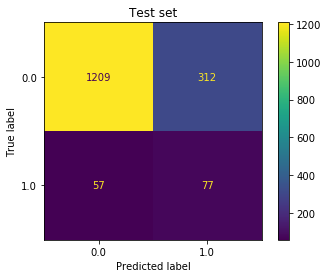

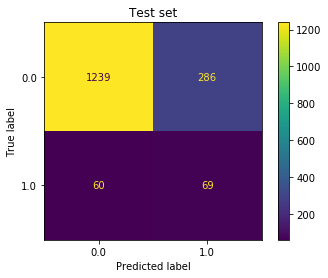

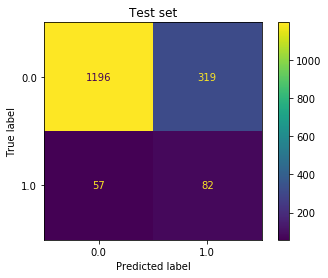

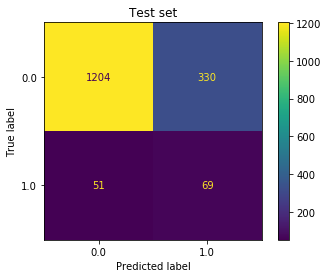

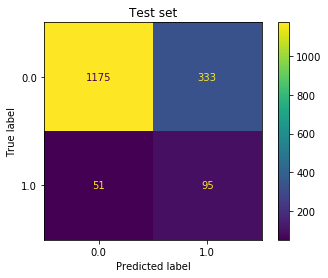

In [43]:
# drop features with lowest weights

# define X and y

X = binary_df_5.drop(columns = ['updated_hosp','RIDRETH3_3.0','RIDAGEYR'])
y = binary_df_5['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

k_fold_validator_2(X_training, y_training, CompNB)

In [44]:
# try age buckets instead of continuous age

binary_df_6 = pd.read_csv('data/binary_df_6').set_index('SEQN')
binary_df_6

osteoarth_binary  other_arth_binary  heart_fail_binary  \
SEQN                                                                   
93703.00000            0.00000            0.00000            0.00000   
93704.00000            0.00000            0.00000            0.00000   
93705.00000            0.00000            1.00000            0.00000   
93706.00000            0.00000            0.00000            0.00000   
93707.00000            0.00000            0.00000            0.00000   
...                        ...                ...                ...   
102952.00000           0.00000            0.00000            0.00000   
102953.00000           0.00000            0.00000            0.00000   
102954.00000           0.00000            0.00000            0.00000   
102955.00000           0.00000            0.00000            0.00000   
102956.00000           1.00000            0.00000            0.00000   

              heart_cond_binary  ever_had_COPD  emphysema_binary  \
SEQN                                                               
93703.00000             0.00000        0.00000           0.00000   
93704.00000             0.00000        0.00000           0.00000   
93705.00000             0.00000        0.00000           0.00000   
93706.00000             0.00000        0.00000           0.00000   
93707.00000             0.00000        0.00000           0.00000   
...                         ...            ...               ...   
102952.00000            0.00000        0.00000           0.00000   
102953.00000            0.00000        0.00000           0.00000   
102954.00000            0.00000        0.00000           0.00000   
102955.00000            0.00000        0.00000           0.00000   
102956.00000            0.00000        0.00000           0.00000   

              chron_bronc_binary  asthma_binary  diabetes_binary  \
SEQN                                                               
93703.00000              0.00000        0.00000          0.00000   
93704.00000              0.00000        0.00000          0.00000   
93705.00000              0.00000        0.00000          0.00000   
93706.00000              0.00000        0.00000          0.00000   
93707.00000              0.00000        0.00000          0.00000   
...                          ...            ...              ...   
102952.00000             0.00000        0.00000          0.00000   
102953.00000             0.00000        0.00000          0.00000   
102954.00000             0.00000        0.00000          0.00000   
102955.00000             0.00000        0.00000          0.00000   
102956.00000             0.00000        0.00000          0.00000   

              taking_ins_binary  updated_hosp  RIDRETH3_1.0  RIDRETH3_2.0  \
SEQN                                                                        
93703.00000             0.00000       0.00000             0             0   
93704.00000             0.00000       0.00000             0             0   
93705.00000             0.00000       0.00000             0             0   
93706.00000             0.00000       0.00000             0             0   
93707.00000             0.00000       0.00000             0             0   
...                         ...           ...           ...           ...   
102952.00000            0.00000       0.00000             0             0   
102953.00000            0.00000       0.00000             1             0   
102954.00000            0.00000       0.00000             0             0   
102955.00000            0.00000       0.00000             0             0   
102956.00000            0.00000       0.00000             0             0   

              RIDRETH3_3.0  RIDRETH3_4.0  RIDRETH3_6.0  num_rx  unknown_dx  \
SEQN                                                                         
93703.00000              0             0             1 0.00000     0.00000   
93704.00000              1             0             0 0.00000     0.00

In [45]:
# define X and y

X = binary_df_6.drop(columns = ['updated_hosp'])
y = binary_df_6['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.733


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.61 +/- 0.04
Test mean precision: 0.22 +/- 0.02
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.56490     5.56490
heart_fail_binary  5.02750     5.02750
chron_bronc_binary 5.00530     5.00530
unknown_dx         4.56740     4.56740
taking_ins_binary  4.54630     4.54630
ever_had_COPD      4.48570     4.48570
heart_cond_binary  3.73230     3.73230
num_rx             3.68380     3.68380
osteoarth_binary   3.52970     3.52970
diabetes_binary    3.28170     3.28170
asthma_binary      3.25270     3.25270
RIDRETH3_2.0       3.23570     3.23570
other_arth_binary  3.19720     3.19720
age_50-59          3.14620     3.14620
age_0-5            3.12090     3.12090
age_70+            3.10930     3.10930
age_60-69          2.90950     2.90950

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


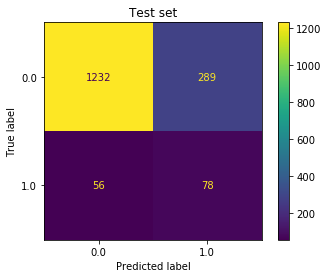

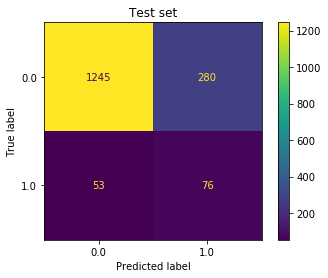

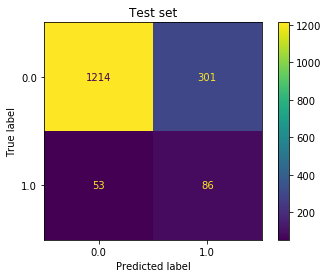

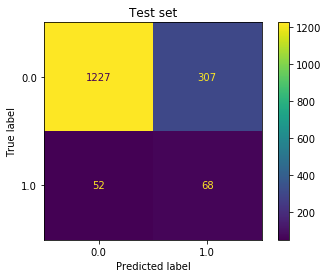

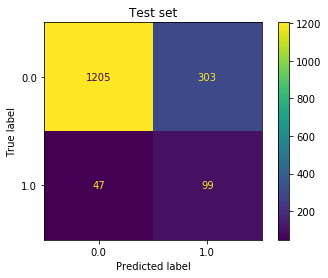

In [46]:
# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

In [47]:
# drop feature with lowest weight

# define X and y

X = binary_df_6.drop(columns = ['updated_hosp', 'age_18-49'])
y = binary_df_6['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.74


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.33 +/- 0.01


Test mean recall: 0.6 +/- 0.04
Test mean precision: 0.22 +/- 0.02
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.40170     5.40170
heart_fail_binary  4.86430     4.86430
chron_bronc_binary 4.84210     4.84210
unknown_dx         4.40420     4.40420
taking_ins_binary  4.38320     4.38320
ever_had_COPD      4.32250     4.32250
heart_cond_binary  3.56920     3.56920
num_rx             3.52060     3.52060
osteoarth_binary   3.36650     3.36650
diabetes_binary    3.11860     3.11860
asthma_binary      3.08960     3.08960
RIDRETH3_2.0       3.07260     3.07260
other_arth_binary  3.03400     3.03400
age_50-59          2.98310     2.98310
age_0-5            2.95770     2.95770
age_70+            2.94610     2.94610
age_60-69          2.74630     2.74630
R

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


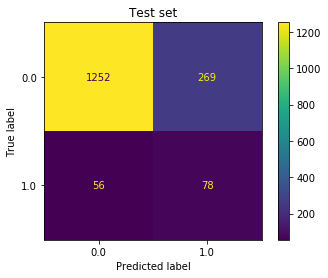

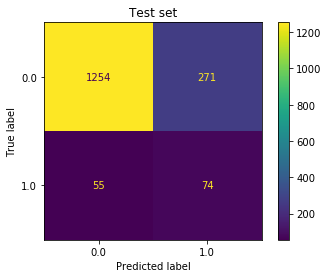

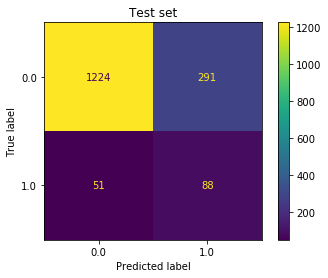

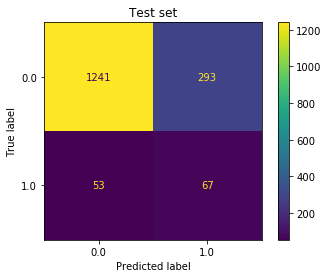

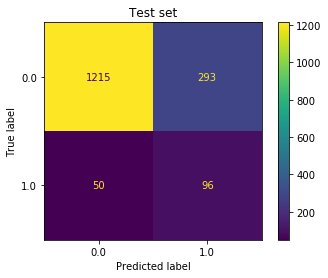

In [48]:
# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# no improvement

In [49]:
# add feature for current liver condition

binary_df_7 = pd.read_csv('data/binary_df_7').set_index('SEQN')
binary_df_7

osteoarth_binary  other_arth_binary  heart_fail_binary  \
SEQN                                                                   
93703.00000            0.00000            0.00000            0.00000   
93704.00000            0.00000            0.00000            0.00000   
93705.00000            0.00000            1.00000            0.00000   
93706.00000            0.00000            0.00000            0.00000   
93707.00000            0.00000            0.00000            0.00000   
...                        ...                ...                ...   
102952.00000           0.00000            0.00000            0.00000   
102953.00000           0.00000            0.00000            0.00000   
102954.00000           0.00000            0.00000            0.00000   
102955.00000           0.00000            0.00000            0.00000   
102956.00000           1.00000            0.00000            0.00000   

              heart_cond_binary  ever_had_COPD  emphysema_binary  \
SEQN                                                               
93703.00000             0.00000        0.00000           0.00000   
93704.00000             0.00000        0.00000           0.00000   
93705.00000             0.00000        0.00000           0.00000   
93706.00000             0.00000        0.00000           0.00000   
93707.00000             0.00000        0.00000           0.00000   
...                         ...            ...               ...   
102952.00000            0.00000        0.00000           0.00000   
102953.00000            0.00000        0.00000           0.00000   
102954.00000            0.00000        0.00000           0.00000   
102955.00000            0.00000        0.00000           0.00000   
102956.00000            0.00000        0.00000           0.00000   

              chron_bronc_binary  asthma_binary  diabetes_binary  \
SEQN                                                               
93703.00000              0.00000        0.00000          0.00000   
93704.00000              0.00000        0.00000          0.00000   
93705.00000              0.00000        0.00000          0.00000   
93706.00000              0.00000        0.00000          0.00000   
93707.00000              0.00000        0.00000          0.00000   
...                          ...            ...              ...   
102952.00000             0.00000        0.00000          0.00000   
102953.00000             0.00000        0.00000          0.00000   
102954.00000             0.00000        0.00000          0.00000   
102955.00000             0.00000        0.00000          0.00000   
102956.00000             0.00000        0.00000          0.00000   

              taking_ins_binary  updated_hosp  RIDRETH3_1.0  RIDRETH3_2.0  \
SEQN                                                                        
93703.00000             0.00000       0.00000             0             0   
93704.00000             0.00000       0.00000             0             0   
93705.00000             0.00000       0.00000             0             0   
93706.00000             0.00000       0.00000             0             0   
93707.00000             0.00000       0.00000             0             0   
...                         ...           ...           ...           ...   
102952.00000            0.00000       0.00000             0             0   
102953.00000            0.00000       0.00000             1             0   
102954.00000            0.00000       0.00000             0             0   
102955.00000            0.00000       0.00000             0             0   
102956.00000            0.00000       0.00000             0             0   

              RIDRETH3_3.0  RIDRETH3_4.0  RIDRETH3_6.0  num_rx  unknown_dx  \
SEQN                                                                         
93703.00000              0             0             1 0.00000     0.00000   
93704.00000              1             0             0 0.00000     0.00

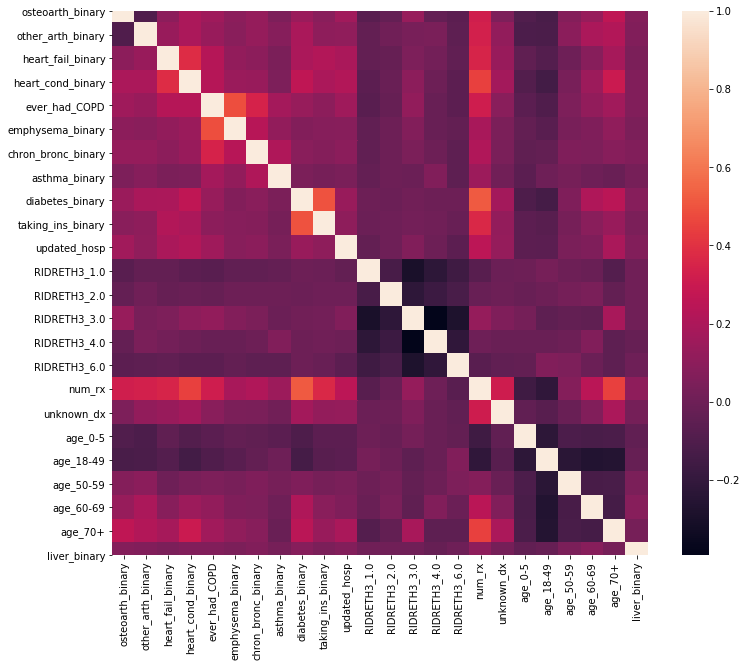

In [50]:
corr = binary_df_7.corr()

plt.figure(figsize = (12,10))
sns.heatmap(corr)

# number of rx is correlated with lots of conditions, but not more than 50%
# COPD and emphysema correlated about 50%

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.734


Train mean recall: 0.62 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.61 +/- 0.04
Test mean precision: 0.21 +/- 0.02
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.57060     5.57060
liver_binary       5.16520     5.16520
heart_fail_binary  5.03320     5.03320
chron_bronc_binary 5.01100     5.01100
unknown_dx         4.57310     4.57310
taking_ins_binary  4.55210     4.55210
ever_had_COPD      4.49140     4.49140
heart_cond_binary  3.73800     3.73800
num_rx             3.68950     3.68950
osteoarth_binary   3.53540     3.53540
diabetes_binary    3.28750     3.28750
asthma_binary      3.25850     3.25850
RIDRETH3_2.0       3.24150     3.24150
other_arth_binary  3.20290     3.20290
age_50-59          3.15200     3.15200
age_0-5            3.12660     3.12660
age_70+            3.11500     3.11500

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


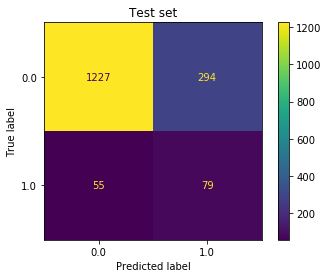

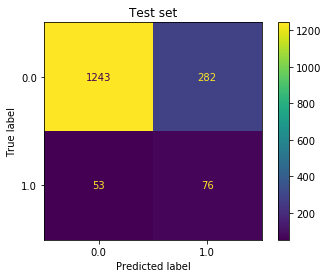

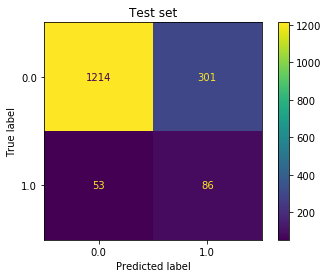

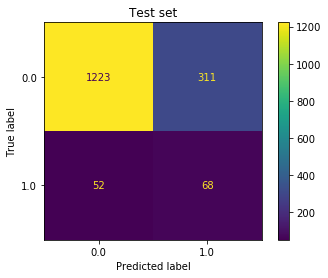

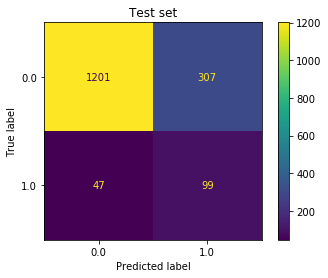

In [51]:
# define X and y

X = binary_df_7.drop(columns = ['updated_hosp'])
y = binary_df_7['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# no improvement

In [52]:
# check how many ppl have current liver condition
binary_df_7['liver_binary'].value_counts()

# very few, but because it has a heavy weight, let's keep it in for now

0    8760
1     134
Name: liver_binary, dtype: int64

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.74


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.33 +/- 0.01


Test mean recall: 0.6 +/- 0.04
Test mean precision: 0.22 +/- 0.02
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.40850     5.40850
liver_binary       5.00300     5.00300
heart_fail_binary  4.87110     4.87110
chron_bronc_binary 4.84890     4.84890
unknown_dx         4.41100     4.41100
taking_ins_binary  4.38990     4.38990
ever_had_COPD      4.32930     4.32930
heart_cond_binary  3.57590     3.57590
num_rx             3.52740     3.52740
osteoarth_binary   3.37330     3.37330
diabetes_binary    3.12530     3.12530
asthma_binary      3.09630     3.09630
RIDRETH3_2.0       3.07930     3.07930
other_arth_binary  3.04080     3.04080
age_50-59          2.98980     2.98980
age_0-5            2.96450     2.96450
age_70+            2.95280     2.95280
a

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


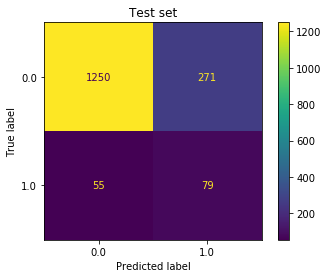

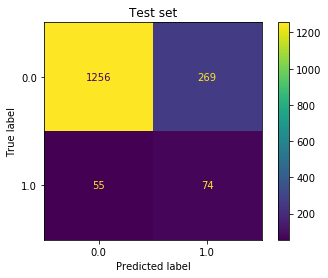

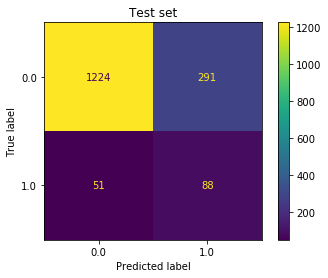

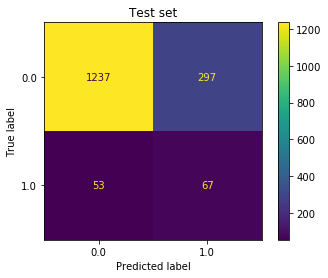

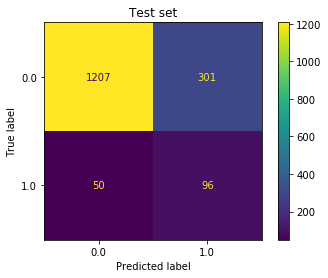

In [53]:
# try dropping column with lowest weight

X = binary_df_7.drop(columns = ['updated_hosp', 'age_18-49'])
y = binary_df_7['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# no improvement

In [67]:
binary_df_8 = pd.read_csv('data/binary_df_8').set_index('SEQN')
binary_df_8.head()

osteoarth_binary  other_arth_binary  heart_fail_binary  \
SEQN                                                                  
93703.00000           0.00000            0.00000            0.00000   
93704.00000           0.00000            0.00000            0.00000   
93705.00000           0.00000            1.00000            0.00000   
93706.00000           0.00000            0.00000            0.00000   
93707.00000           0.00000            0.00000            0.00000   

             heart_cond_binary  ever_had_COPD  emphysema_binary  \
SEQN                                                              
93703.00000            0.00000        0.00000           0.00000   
93704.00000            0.00000        0.00000           0.00000   
93705.00000            0.00000        0.00000           0.00000   
93706.00000            0.00000        0.00000           0.00000   
93707.00000            0.00000        0.00000           0.00000   

             chron_bronc_binary  asthma_binary  diabetes_binary  \
SEQN                                                              
93703.00000             0.00000        0.00000          0.00000   
93704.00000             0.00000        0.00000          0.00000   
93705.00000             0.00000        0.00000          0.00000   
93706.00000             0.00000        0.00000          0.00000   
93707.00000             0.00000        0.00000          0.00000   

             taking_ins_binary  updated_hosp  RIDRETH3_1.0  RIDRETH3_2.0  \
SEQN                                                                       
93703.00000            0.00000       0.00000             0             0   
93704.00000            0.00000       0.00000             0             0   
93705.00000            0.00000       0.00000             0             0   
93706.00000            0.00000       0.00000             0             0   
93707.00000            0.00000       0.00000             0             0   

             RIDRETH3_3.0  RIDRETH3_4.0  RIDRETH3_6.0  num_rx  unknown_dx  \
SEQN                                                                        
93703.00000             0             0             1 0.00000     0.00000   
93704.00000             1             0             0 0.00000     0.00000   
93705.00000             0             1             0 2.00000     0.00000   
93706.00000             0             0             1 0.00000     0.00000   
93707.00000             0             0             0 0.00000     0.00000   

             age_0-5  age_18-49  age_50-59  age_60-69  age_70+  liver_binary  \
SEQN                                                                           
93703.00000        1          0          0          0        0             0   
93704.00000        1          0          0          0        0             0   
93705.00000        0          0          0          1        0             0   
93706.00000        0          1          0          0        0             0   
93707.00000        0          0          0          0        0             0   

             recent_cancer  
SEQN                        
93703.00000              0  
93704.00000              0  
93705.00000              0  
93706.00000              0  
93707.00000              0

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.737


Train mean recall: 0.62 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.61 +/- 0.05
Test mean precision: 0.21 +/- 0.03
Test mean F1: 0.32 +/- 0.04


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.58210     5.58210
liver_binary       5.17660     5.17660
heart_fail_binary  5.04470     5.04470
chron_bronc_binary 5.02240     5.02240
unknown_dx         4.58450     4.58450
taking_ins_binary  4.56350     4.56350
ever_had_COPD      4.50290     4.50290
recent_cancer      4.47710     4.47710
heart_cond_binary  3.74950     3.74950
num_rx             3.70100     3.70100
osteoarth_binary   3.54690     3.54690
diabetes_binary    3.29890     3.29890
asthma_binary      3.26990     3.26990
RIDRETH3_2.0       3.25290     3.25290
other_arth_binary  3.21430     3.21430
age_50-59          3.16340     3.16340
age_0-5            3.13800     3.13800

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


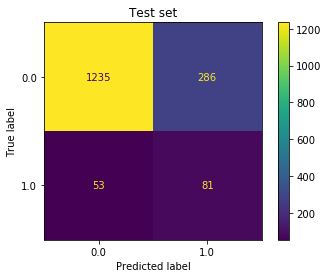

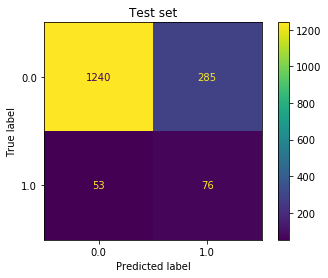

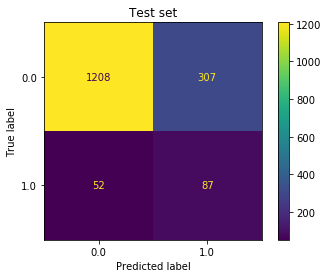

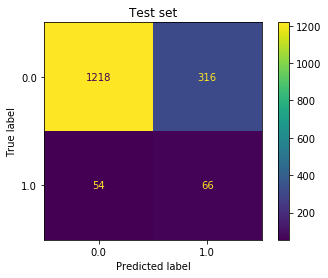

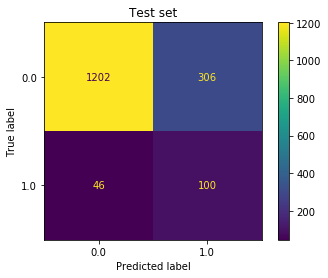

In [68]:
# try adding recent cancer dx

X = binary_df_8.drop(columns = ['updated_hosp'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# no improvement

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.736


Train mean recall: 0.62 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.61 +/- 0.04
Test mean precision: 0.21 +/- 0.02
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.57640     5.57640
heart_fail_binary  5.03900     5.03900
chron_bronc_binary 5.01680     5.01680
unknown_dx         4.57890     4.57890
taking_ins_binary  4.55780     4.55780
ever_had_COPD      4.49720     4.49720
recent_cancer      4.47140     4.47140
heart_cond_binary  3.74380     3.74380
num_rx             3.69530     3.69530
osteoarth_binary   3.54120     3.54120
diabetes_binary    3.29320     3.29320
asthma_binary      3.26420     3.26420
RIDRETH3_2.0       3.24720     3.24720
other_arth_binary  3.20870     3.20870
age_50-59          3.15770     3.15770
age_0-5            3.13240     3.13240
age_70+            3.12080     3.12080

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


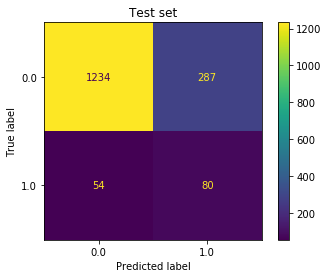

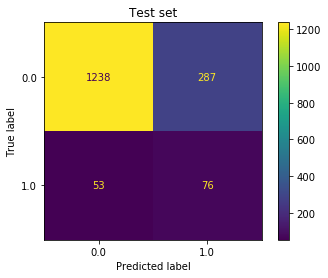

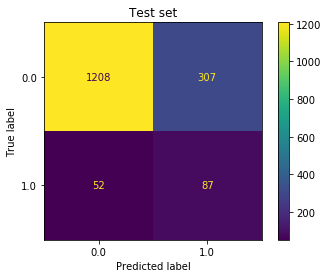

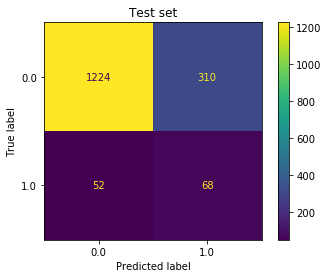

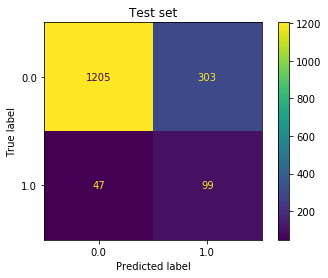

In [69]:
# try dropping liver

X = binary_df_8.drop(columns = ['updated_hosp', 'liver_binary'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# no improvement

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.742


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.6 +/- 0.04
Test mean precision: 0.22 +/- 0.02
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.41530     5.41530
heart_fail_binary  4.87790     4.87790
chron_bronc_binary 4.85560     4.85560
unknown_dx         4.41770     4.41770
taking_ins_binary  4.39670     4.39670
ever_had_COPD      4.33610     4.33610
recent_cancer      4.31030     4.31030
heart_cond_binary  3.58270     3.58270
num_rx             3.53420     3.53420
osteoarth_binary   3.38010     3.38010
diabetes_binary    3.13210     3.13210
asthma_binary      3.10310     3.10310
RIDRETH3_2.0       3.08610     3.08610
other_arth_binary  3.04750     3.04750
age_50-59          2.99660     2.99660
age_0-5            2.97120     2.97120
age_70+            2.95960     2.95960


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


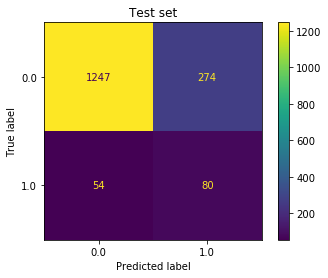

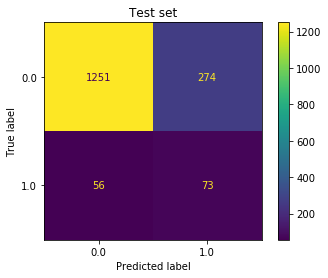

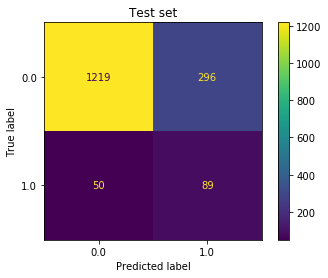

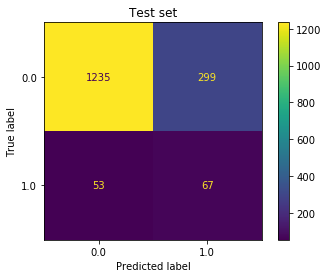

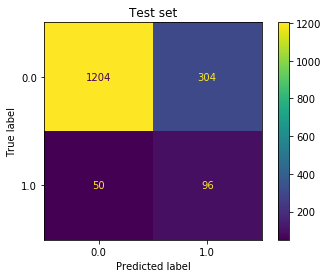

In [70]:
# try dropping liver and least weighted features

X = binary_df_8.drop(columns = ['updated_hosp', 'liver_binary', 'age_18-49'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# recall worse

In [ ]:
# test holdout set with binary_df_8 and all columns
# liver and cancer didn't seem to improve scores, but with a larger dataset they might

X = binary_df_8.drop(columns = ['updated_hosp'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

Classifier: KNeighborsClassifier()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.639


Train mean recall: 0.12 +/- 0.01
Train mean precision: 0.64 +/- 0.04
Train mean F1: 0.21 +/- 0.02


Test mean recall: 0.03 +/- 0.01
Test mean precision: 0.24 +/- 0.04
Test mean F1: 0.06 +/- 0.01




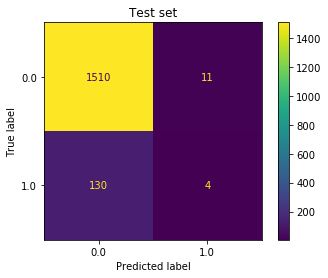

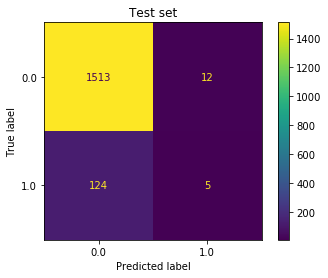

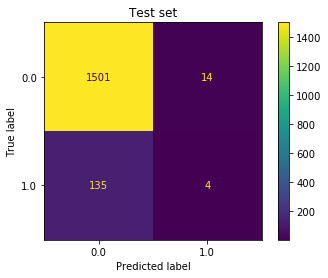

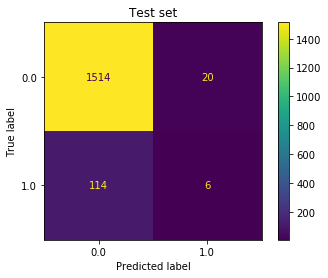

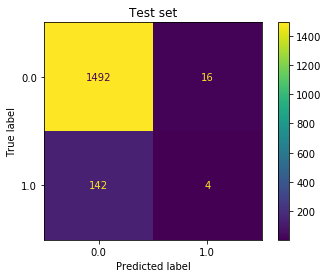

In [54]:
knn = KNeighborsClassifier()

k_fold_validator_2(X_training, y_training, knn)

# very slight improvement in test precision

In [55]:
nn = Sequential()

# Input layer with dropout
nn.add(layers.Dropout(0.3))

# First hidden layer
nn.add(layers.Dense(10, activation='relu'))
nn.add(layers.Dropout(0.3))

# Second hidden layer
nn.add(layers.Dense(10, activation='relu'))
nn.add(layers.Dropout(0.3))

# Third hidden layer
nn.add(layers.Dense(10, activation='relu'))
nn.add(layers.Dropout(0.3))

# Output layer
nn.add(layers.Dense(1, activation='linear'))

# Compile the model
nn.compile(optimizer='SGD', 
              loss='mse',  
              metrics=['accuracy']) 

# Return the compiled model


In [56]:
y_training_array = y_training.to_numpy().reshape((8271,1))

In [57]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

In [58]:
X_train_scaled_reindex = X_train_scaled.reset_index(drop=True)
X_train_scaled_reindex

osteoarth_binary  other_arth_binary  heart_fail_binary  \
0             -0.28862           -0.34220           -0.15251   
1             -0.28862           -0.34220           -0.15251   
2             -0.28862           -0.34220           -0.15251   
3             -0.28862           -0.34220           -0.15251   
4             -0.28862           -0.34220           -0.15251   
...                ...                ...                ...   
8266          -0.28862           -0.34220           -0.15251   
8267          -0.28862           -0.34220           -0.15251   
8268          -0.28862           -0.34220            6.55703   
8269          -0.28862           -0.34220           -0.15251   
8270          -0.28862           -0.34220           -0.15251   

      heart_cond_binary  ever_had_COPD  emphysema_binary  chron_bronc_binary  \
0              -0.27308       -0.18440          -0.10837            -0.14090   
1               3.66189       -0.18440          -0.10837            -0.14090   
2              -0.27308       -0.18440          -0.10837            -0.14090   
3              -0.27308       -0.18440          -0.10837            -0.14090   
4              -0.27308       -0.18440          -0.10837            -0.14090   
...                 ...            ...               ...                 ...   
8266           -0.27308       -0.18440          -0.10837            -0.14090   
8267           -0.27308       -0.18440          -0.10837            -0.14090   
8268           -0.27308       -0.18440          -0.10837            -0.14090   
8269           -0.27308       -0.18440          -0.10837            -0.14090   
8270           -0.27308       -0.18440          -0.10837            -0.14090   

      asthma_binary  diabetes_binary  taking_ins_binary  RIDRETH3_1.0  \
0          -0.31090         -0.32655           -0.17138      -0.41196   
1          -0.31090         -0.32655           -0.17138      -0.41196   
2          -0.31090         -0.32655           -0.17138      -0.41196   
3          -0.31090         -0.32655           -0.17138       2.42745   
4          -0.31090         -0.32655           -0.17138      -0.41196   
...             ...              ...                ...           ...   
8266       -0.31090         -0.32655           -0.17138      -0.41196   
8267       -0.31090         -0.32655           -0.17138      -0.41196   
8268       -0.31090         -0.32655           -0.17138      -0.41196   
8269        3.21647         -0.32655           -0.17138      -0.41196   
8270       -0.31090         -0.32655           -0.17138      -0.41196   

      RIDRETH3_2.0  RIDRETH3_3.0  RIDRETH3_4.0  RIDRETH3_6.0   num_rx  \
0         -0.31137       1.40389      -0.54983      -0.38775 -0.52658   
1         -0.31137       1.40389      -0.54983      -0.38775 -0.11016   
2         -0.31137       1.40389      -0.54983      -0.38775 -0.52658   
3         -0.31137      -0.71231      -0.54983      -0.38775 -0.52658   
4          3.21164      -0.71231      -0.54983      -0.38775 -0.52658   
...            ...           ...           ...           ...      ...   
8266      -0.31137      -0.71231       1.81874      -0.38775 -0.52658   
8267      -0.31137      -0.71231      -0.54983      -0.38775 -0.52658   
8268      -0.31137       1.40389      -0.54983      -0.38775 -0.11016   
8269      -0.31137      -0.71231      -0.54983      -0.38775 -0.52658   
8270      -0.31137       1.40389      -0.54983      -0.38775 -0.52658   

      unknown_dx  age_0-5  age_50-59  age_60-69  age_70+  liver_binary  
0       -0.17508 -0.32337   -0.33932   -0.37924 -0.36599      -0.12438  
1       -0.17508 -0.32337   -0.33932   -0.37924 -0.36599      -0.12438  
2       -0.17508 -0.32337   -0.33932   -0.37924 -0.36599      -0.12438  
3       -0.17508 -0.32337   -0.33932   -0.37924 -0.36599      -0.12438  
4       -0.17508 -0.32337   -0.33932   -0.37924 -0.36599      -0.12438  
...          ...      ...        ...        ...      ...           ...  
8266    -0.

In [59]:
# always predicting majority class, not learning anything

nn.fit(X_train_scaled_reindex, y_training_array, epochs=10, validation_split=0.1)

Epoch 1/10
233/233 [==============================] - 1s 2ms/step - loss: 0.2840 - accuracy: 0.8772 - val_loss: 0.0715 - val_accuracy: 0.9203
Epoch 2/10
233/233 [==============================] - 0s 824us/step - loss: 0.0798 - accuracy: 0.9166 - val_loss: 0.0723 - val_accuracy: 0.9203
Epoch 3/10
233/233 [==============================] - 0s 903us/step - loss: 0.0735 - accuracy: 0.9206 - val_loss: 0.0707 - val_accuracy: 0.9203
Epoch 4/10
233/233 [==============================] - 0s 881us/step - loss: 0.0787 - accuracy: 0.9127 - val_loss: 0.0713 - val_accuracy: 0.9203
Epoch 5/10
233/233 [==============================] - 0s 756us/step - loss: 0.0719 - accuracy: 0.9211 - val_loss: 0.0716 - val_accuracy: 0.9203
Epoch 6/10
233/233 [==============================] - 0s 904us/step - loss: 0.0722 - accuracy: 0.9203 - val_loss: 0.0709 - val_accuracy: 0.9203
Epoch 7/10
233/233 [==============================] - 0s 913us/step - loss: 0.0724 - accuracy: 0.9189 - val_loss: 0.0701 - val_accuracy: 0

Classifier: DecisionTreeClassifier(min_samples_split=3)
Cross-validation folds: 5


Mean ROC-AUC Score: 0.476


Train mean recall: 0.42 +/- 0.01
Train mean precision: 0.99 +/- 0.0
Train mean F1: 0.59 +/- 0.01


Test mean recall: 0.14 +/- 0.01
Test mean precision: 0.28 +/- 0.08
Test mean F1: 0.19 +/- 0.03


Feature weights: 
                     weight  abs_weight
num_rx             0.25930     0.25930
other_arth_binary  0.05220     0.05220
RIDRETH3_4.0       0.05010     0.05010
age_70+            0.04710     0.04710
age_50-59          0.04660     0.04660
age_60-69          0.04520     0.04520
unknown_dx         0.04320     0.04320
osteoarth_binary   0.04220     0.04220
diabetes_binary    0.04190     0.04190
RIDRETH3_3.0       0.03780     0.03780
chron_bronc_binary 0.03760     0.03760
heart_fail_binary  0.03760     0.03760
RIDRETH3_1.0       0.03380     0.03380
taking_ins_binary  0.03290     0.03290
ever_had_COPD      0.03190     0.03190
asthma_binary      0.03070     0.03070
heart_cond

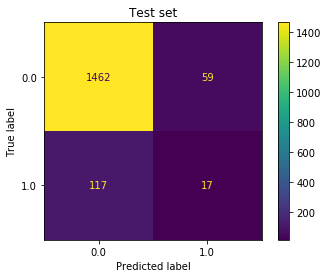

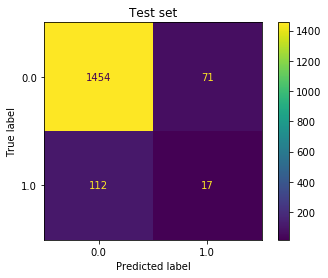

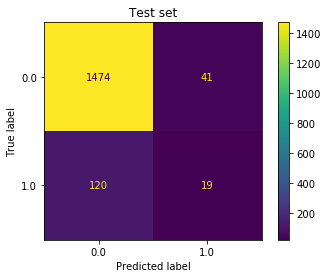

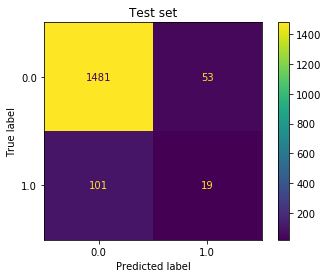

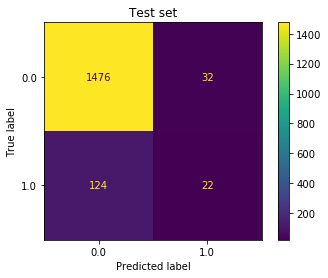

In [60]:
# try a decision tree agin

tree = DecisionTreeClassifier(min_samples_split=3)

k_fold_validator_2(X_training, y_training, tree)

Classifier: GridSearchCV(cv=3, estimator=DecisionTreeClassifier(min_samples_split=3),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 4, 6, 8],
                         'max_features': [10, 13, 16],
                         'min_samples_leaf': [10, 12, 14],
                         'min_samples_split': [8, 10, 12]})
Cross-validation folds: 5


Mean ROC-AUC Score: 0.719


Train mean recall: 0.04 +/- 0.02
Train mean precision: 0.65 +/- 0.07
Train mean F1: 0.08 +/- 0.03


Test mean recall: 0.02 +/- 0.01
Test mean precision: 0.38 +/- 0.19
Test mean F1: 0.05 +/- 0.02




AttributeError: 'GridSearchCV' object has no attribute 'coef_'

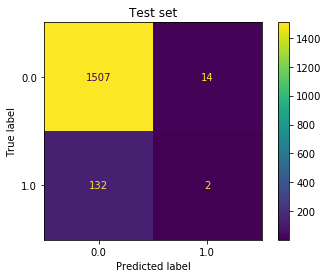

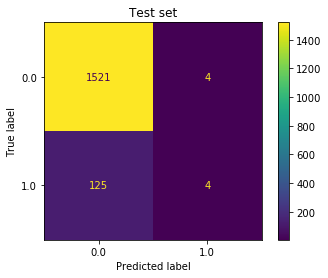

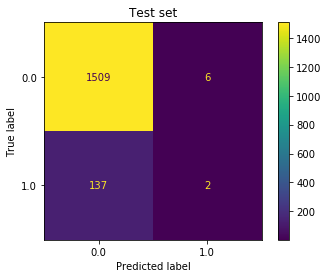

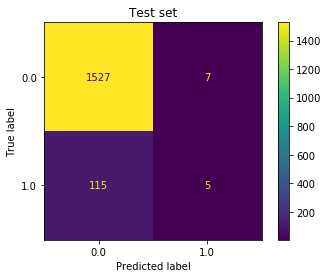

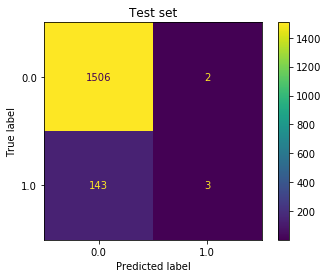

In [61]:
tree_param_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 4, 6, 8],
                 'min_samples_leaf': [10, 12, 14],
                 'min_samples_split': [8, 10, 12],
                  'max_features': [10, 13, 16]}
                 
tree_grid_search = GridSearchCV(tree, tree_param_grid, cv=3)

k_fold_validator_2(X_training, y_training, tree_grid_search)

In [62]:
tree_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 13,
 'min_samples_leaf': 10,
 'min_samples_split': 12}

In [63]:
tree_grid_search.best_estimator_.feature_importances_

array([0.01842963, 0.01642059, 0.0942845 , 0.10458841, 0.        ,
       0.        , 0.        , 0.        , 0.0131964 , 0.00445243,
       0.        , 0.        , 0.00674637, 0.00203714, 0.        ,
       0.65889554, 0.        , 0.        , 0.        , 0.        ,
       0.08094899, 0.        ])

Classifier: GridSearchCV(cv=3, estimator=DecisionTreeClassifier(min_samples_split=3),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 4, 6, 8],
                         'max_features': [10, 13, 16],
                         'min_samples_leaf': [10, 12, 14],
                         'min_samples_split': [8, 10, 12]},
             scoring='recall')
Cross-validation folds: 2


Mean ROC-AUC Score: 0.712


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1777, in recall_score
    zero_



Train mean recall: 0.08 +/- 0.01
Train mean precision: 0.6 +/- 0.02
Train mean F1: 0.14 +/- 0.01


Test mean recall: 0.04 +/- 0.01
Test mean precision: 0.31 +/- 0.07
Test mean F1: 0.08 +/- 0.02




AttributeError: 'GridSearchCV' object has no attribute 'coef_'

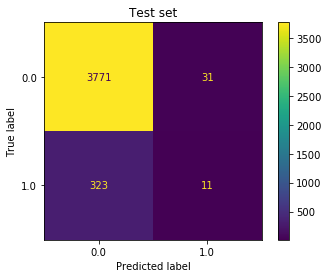

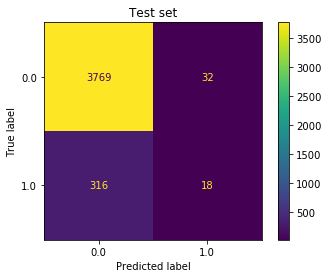

In [65]:
tree_grid_search = GridSearchCV(tree, tree_param_grid, cv=3, scoring='recall')

k_fold_validator_2(X_training, y_training, tree_grid_search, cv=2)

In [ ]:
y_training.value_counts(normalize=True)

In [ ]:
tree_grid_search.best_params_

In [ ]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=10,
                                min_samples_leaf=10, min_samples_split=8)
forest.fit(X_training, y_training)

In [ ]:
k_fold_validator(X_training, y_training, forest, cv=2)

In [ ]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_training, y_training)

In [ ]:
CompNB = ComplementNB()

k_fold_validator_2(X_smote, y_smote, CompNB)

# smote does not help recall

In [ ]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=10,
                                min_samples_leaf=10, min_samples_split=8)

In [ ]:
k_fold_validator_2(X_smote, y_smote, forest)

# smote does help recall

In [ ]:
forest.fit(X_smote, y_smote)

y_pred = forest.predict(X_holdout)

In [ ]:
y_pred

In [ ]:
print(recall_score(y_holdout, y_pred),
precision_score(y_holdout, y_pred),
      accuracy_score(y_holdout, y_pred))